### ***Task : Apply supervised learning methods to build a predictive model for GSNR using an Artificial Neural Network (ANN), perform hyperparameter tuning through grid search to find the best parameters, analyze the effects of learning rate, batch size, and other hyperparameters.***

In [1]:
!pip install tensorflow==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    F

In [1]:
pip install keras==2.12.0

In [2]:
pip install keras-tuner

  Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD, RMSprop

**1. Data Exploration and Preprocessing**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
# Load the dataset
data = pd.read_excel('/content/DataSet_EU_3k_5k.xlsx')

In [6]:
# Inspect the first few rows of the dataset
print(data.head())

    Power_1   Power_2   Power_3   Power_4   Power_5   Power_6   Power_7  \
0  0.000000  0.000000  0.000007  0.000007  0.000007  0.000000  0.000007   
1  0.000000  0.000007  0.000000  0.000007  0.000000  0.000007  0.000000   
2  0.000000  0.000000  0.000000  0.000007  0.000000  0.000000  0.000000   
3  0.000007  0.000007  0.000007  0.000007  0.000007  0.000000  0.000000   
4  0.000000  0.000000  0.000007  0.000000  0.000007  0.000000  0.000000   

   Power_8   Power_9  Power_10  ...    GSNR_69    GSNR_70    GSNR_71  \
0      0.0  0.000007       0.0  ...  90.061284   0.000000   0.000000   
1      0.0  0.000000       0.0  ...   0.000000  92.560867   0.000000   
2      0.0  0.000007       0.0  ...   0.000000   0.000000  90.991977   
3      0.0  0.000007       0.0  ...  76.409583  73.664915  74.651700   
4      0.0  0.000007       0.0  ...   0.000000   0.000000  78.299438   

     GSNR_72    GSNR_73    GSNR_74    GSNR_75    GSNR_76  No. Spans  \
0   0.000000   0.000000  95.045789   0.000000

**2. Feature Selection**

In [7]:
# Extract relevant columns: first 'GSNR' and discard 'Frequency' columns
gsnr_columns = [col for col in data.columns if 'GSNR' in col]
frequency_columns = [col for col in data.columns if 'frequency' in col]

In [8]:
# Keep only the first GSNR column and discard the rest
gsnr_column = gsnr_columns[0]
data = data.drop(columns=gsnr_columns[1:])

In [9]:
# Discard all Frequency columns
data = data.drop(columns=frequency_columns)

In [10]:
# Check the remaining columns
print(data.columns)

# Check for missing values
print(data.isnull().sum())

# Handle missing values if any (e.g., imputation or removal)
data = data.dropna()

Index(['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6',
       'Power_7', 'Power_8', 'Power_9', 'Power_10',
       ...
       'ASE_70', 'ASE_71', 'ASE_72', 'ASE_73', 'ASE_74', 'ASE_75', 'ASE_76',
       'GSNR_1', 'No. Spans', 'Total Distance(m)'],
      dtype='object', length=231)
Power_1              0
Power_2              0
Power_3              0
Power_4              0
Power_5              0
                    ..
ASE_75               0
ASE_76               0
GSNR_1               0
No. Spans            0
Total Distance(m)    0
Length: 231, dtype: int64


In [11]:
# Describe the dataset to understand feature distributions
print(data.describe())

            Power_1       Power_2       Power_3       Power_4       Power_5  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean       0.000024      0.000024      0.000024      0.000023      0.000023   
std        0.000038      0.000038      0.000038      0.000038      0.000038   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000019      0.000019      0.000019      0.000019      0.000019   
max        0.000095      0.000095      0.000095      0.000095      0.000095   

            Power_6       Power_7       Power_8       Power_9      Power_10  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean       0.000024      0.000024      0.000024      0.000023      0.000023   
std        0.000038      0.000038      0.000038    

**3. Visualization**

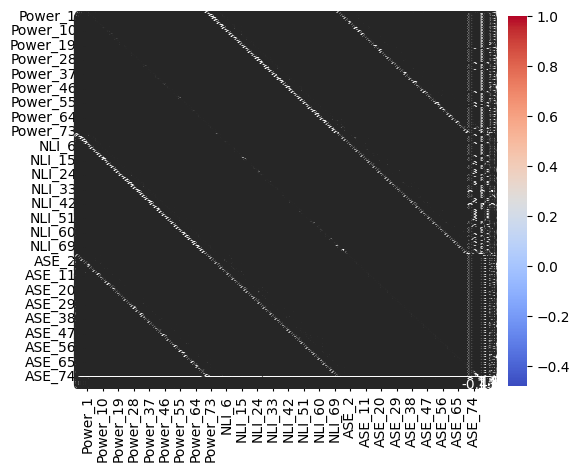

In [12]:
# Visualize the correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [13]:
# Split features and target variable
X = data.drop(columns=[gsnr_column])
y = data[gsnr_column]

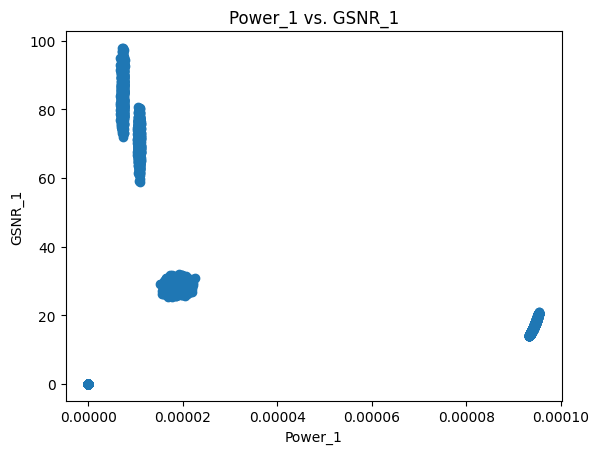

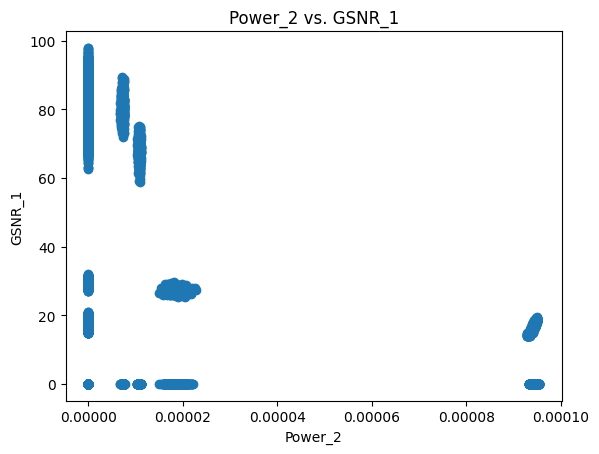

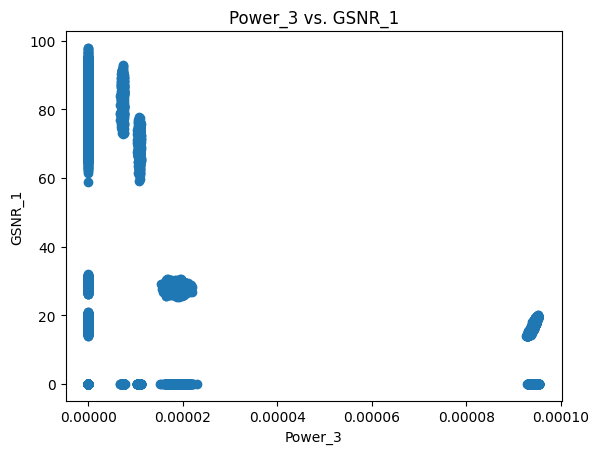

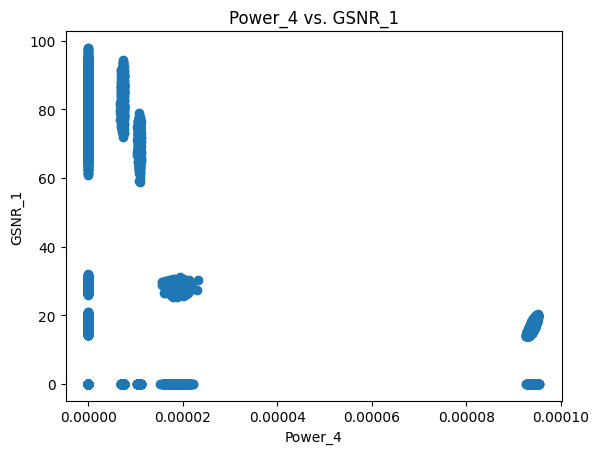

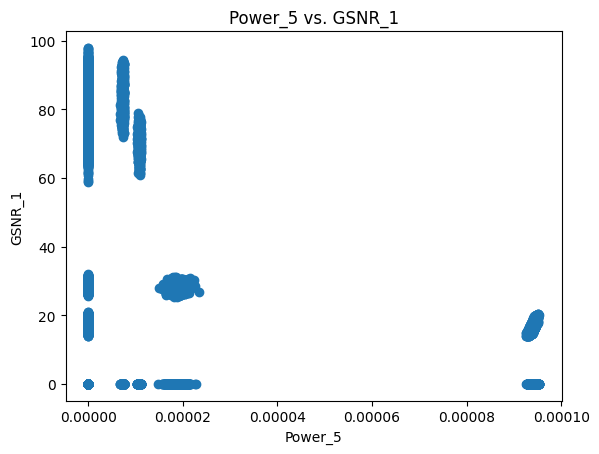

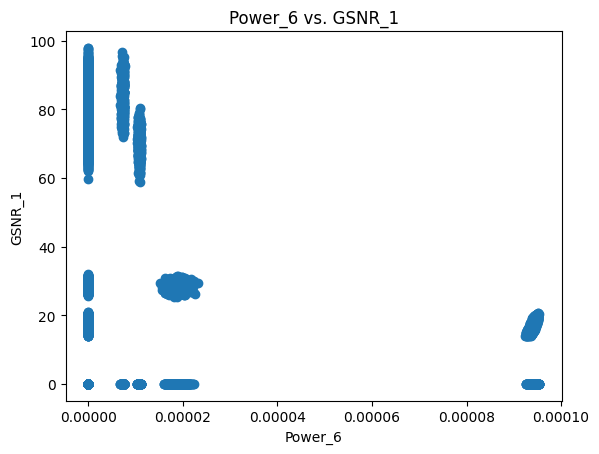

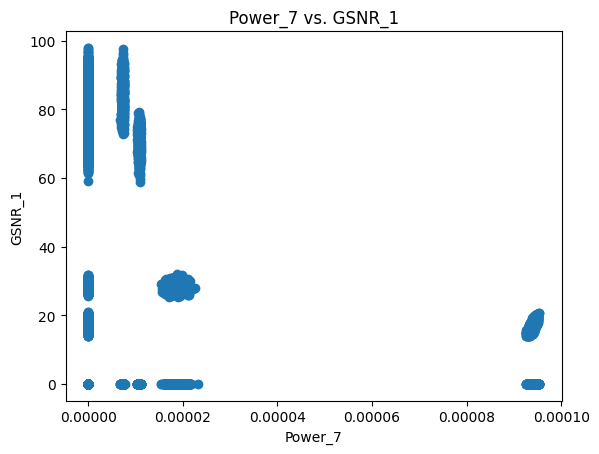

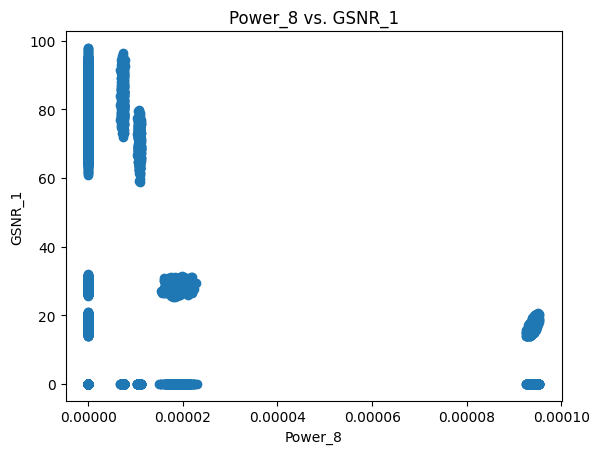

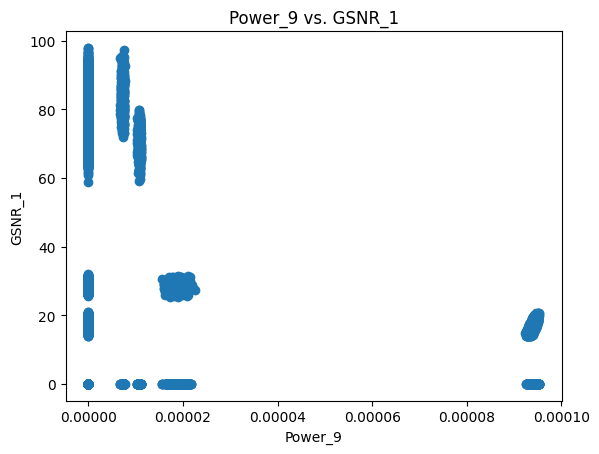

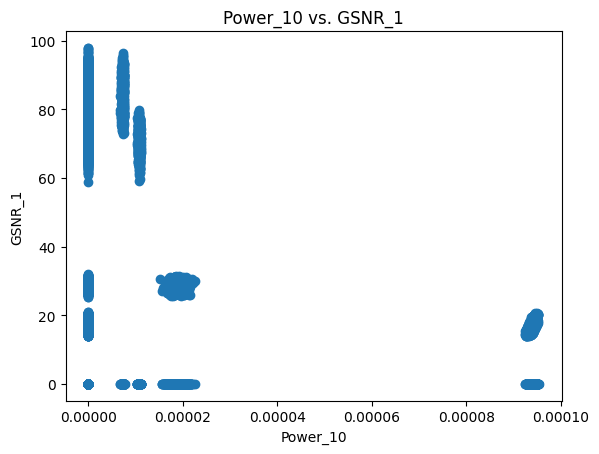

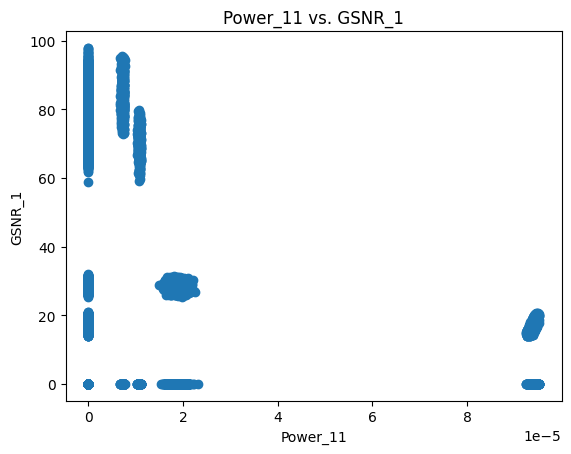

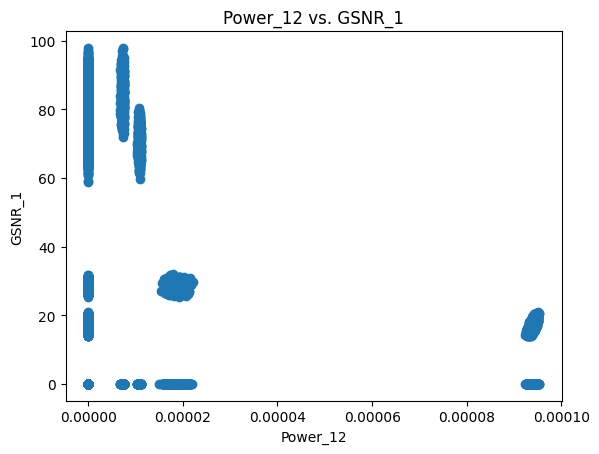

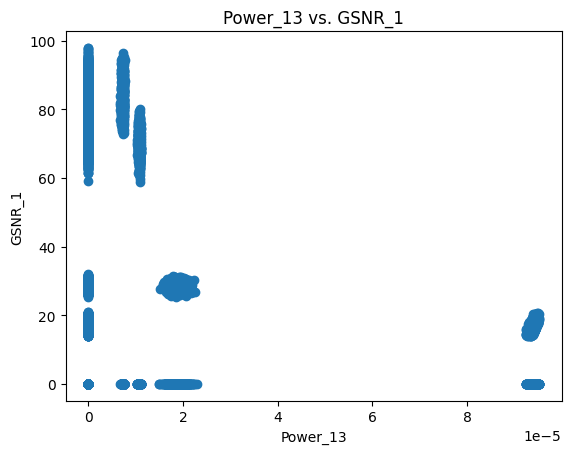

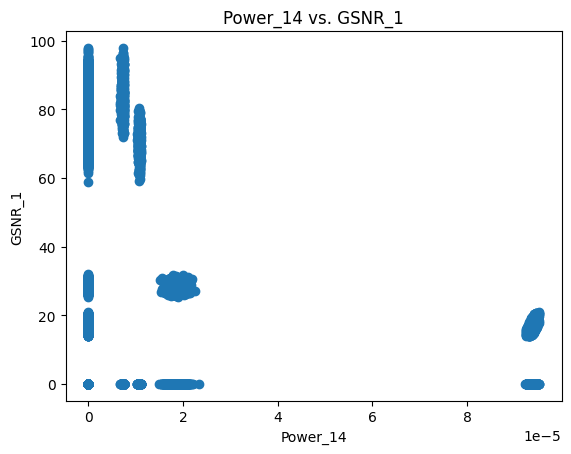

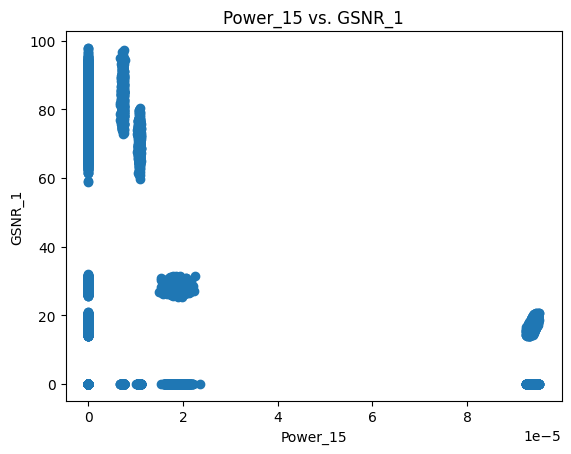

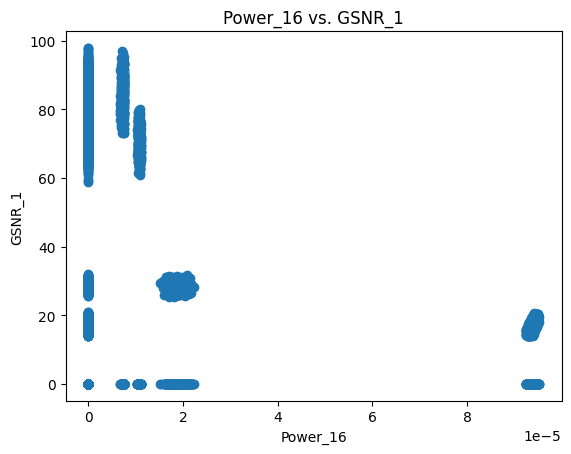

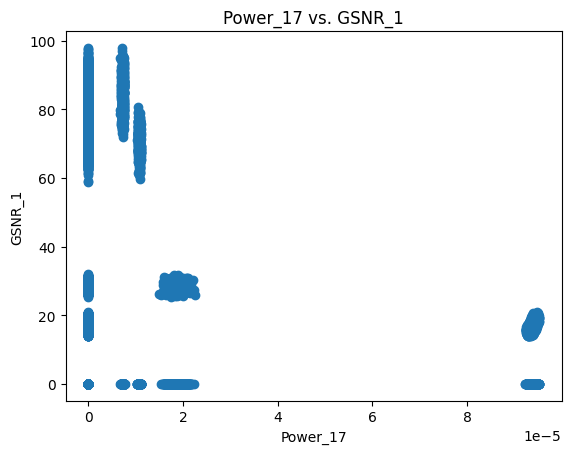

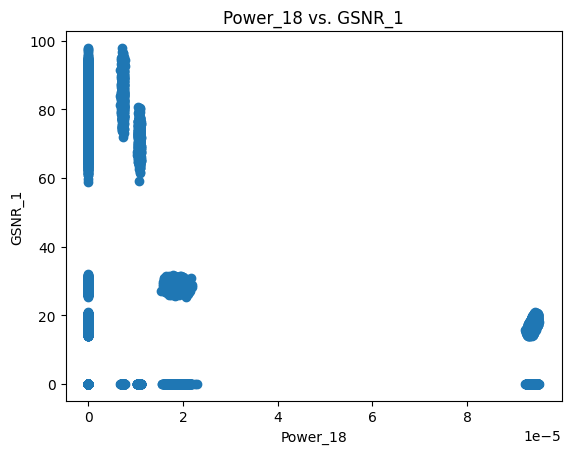

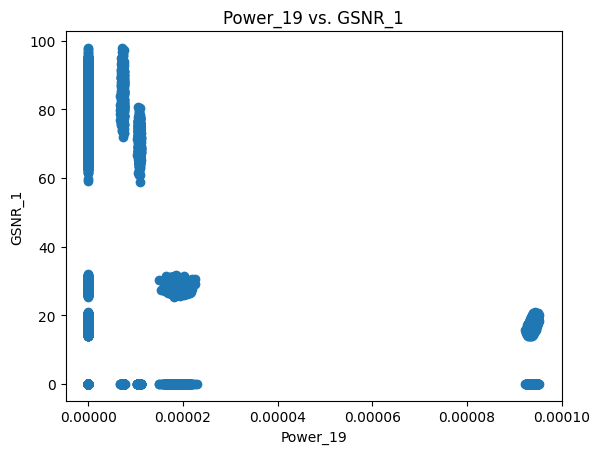

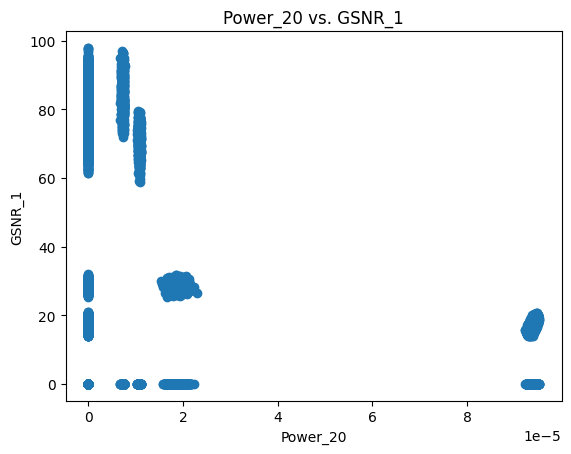

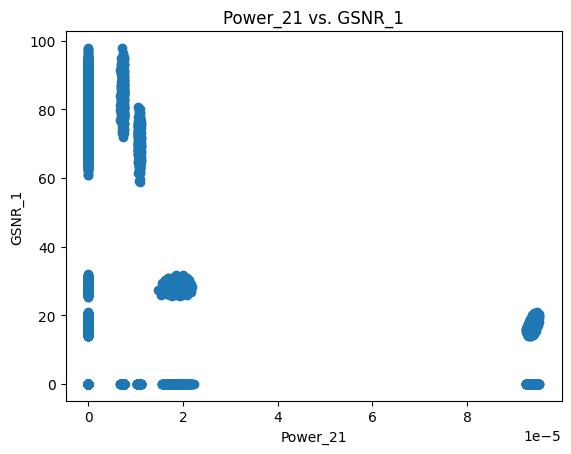

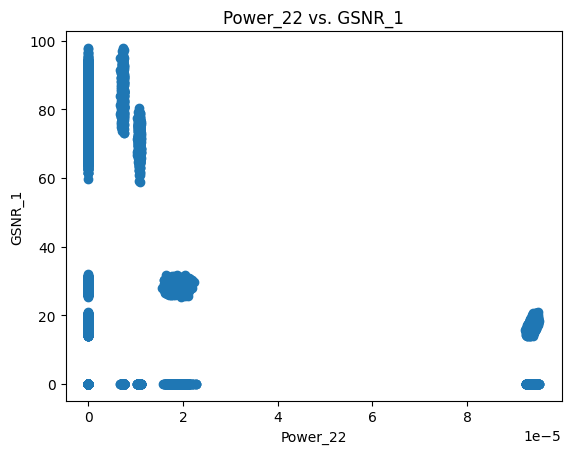

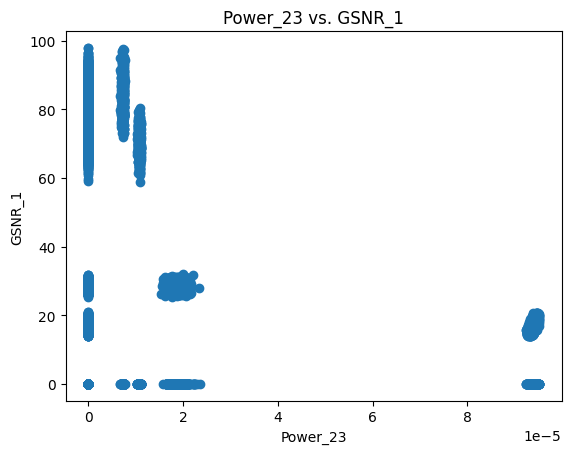

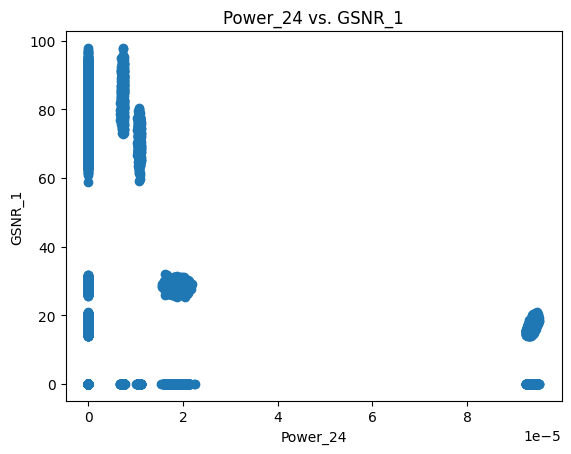

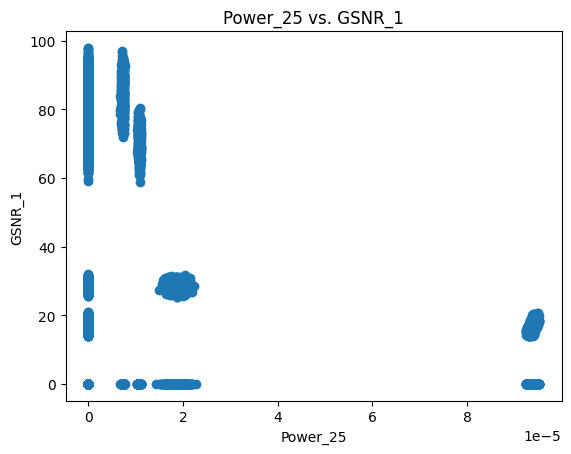

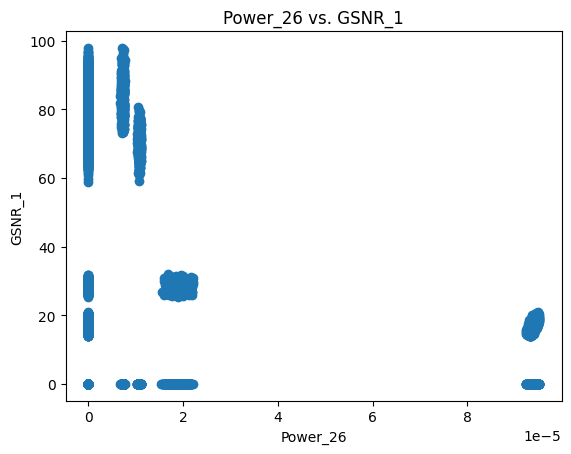

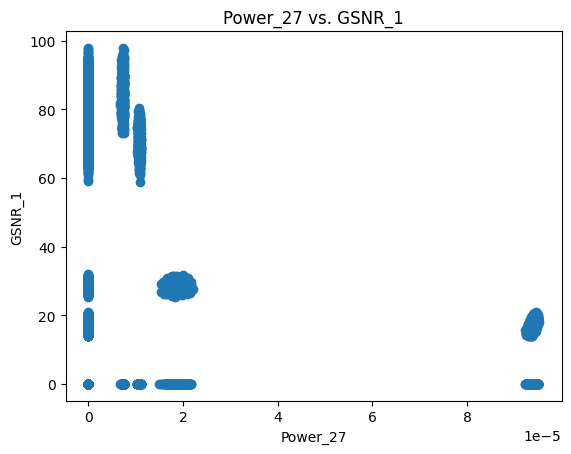

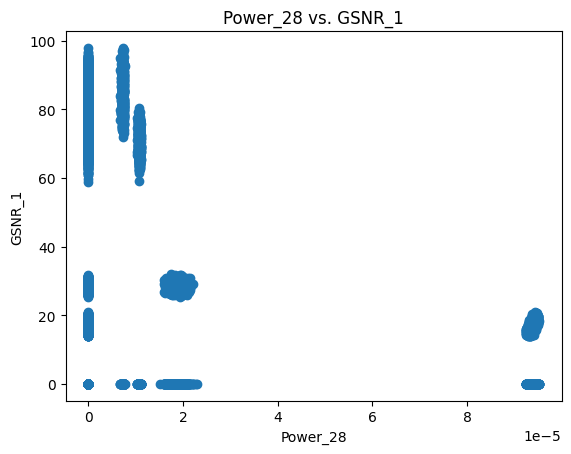

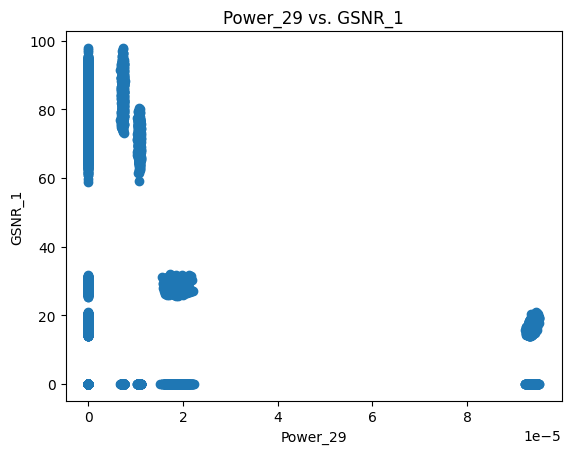

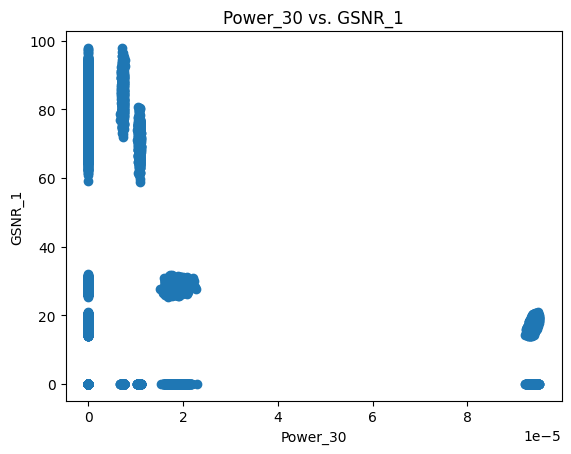

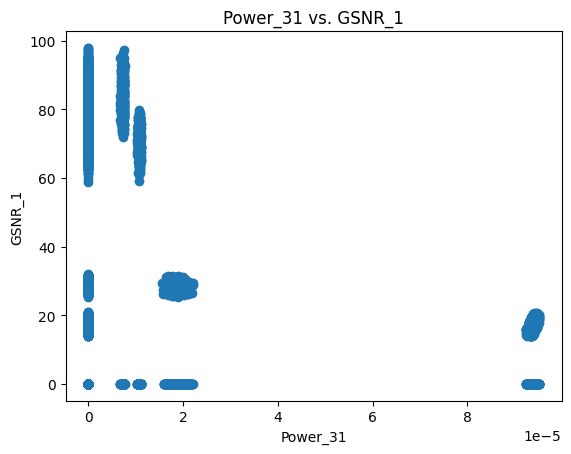

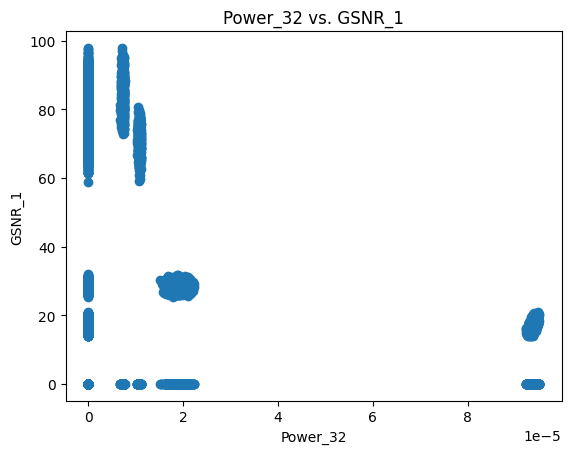

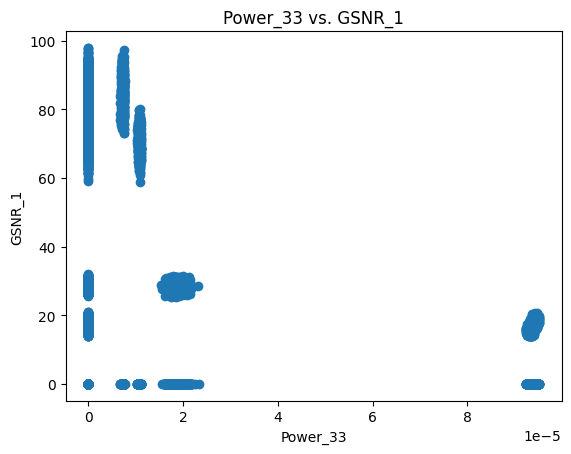

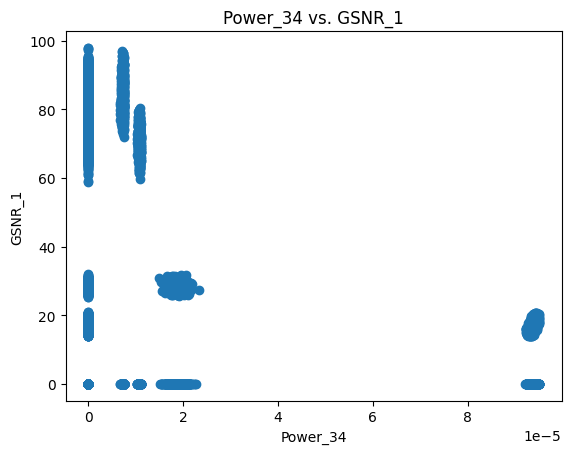

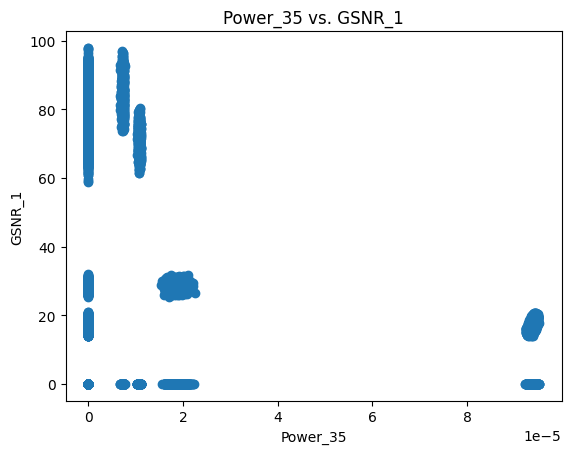

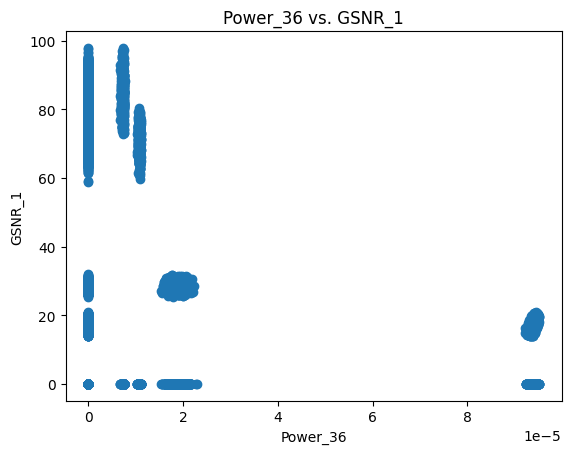

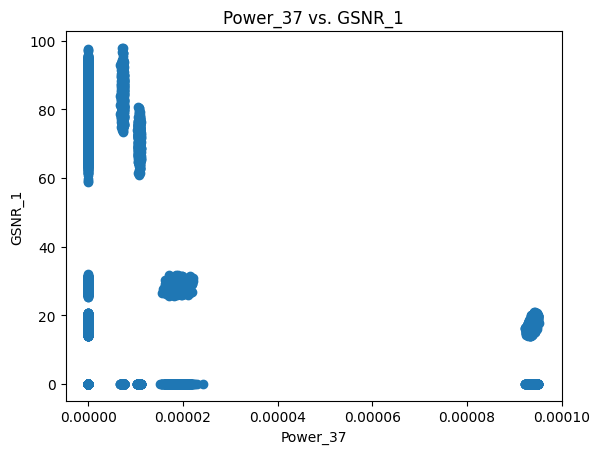

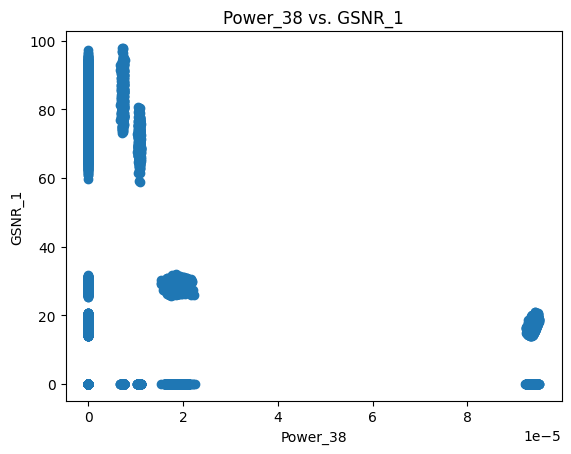

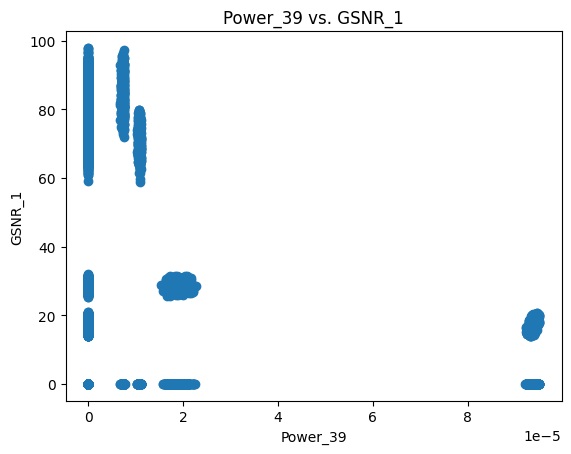

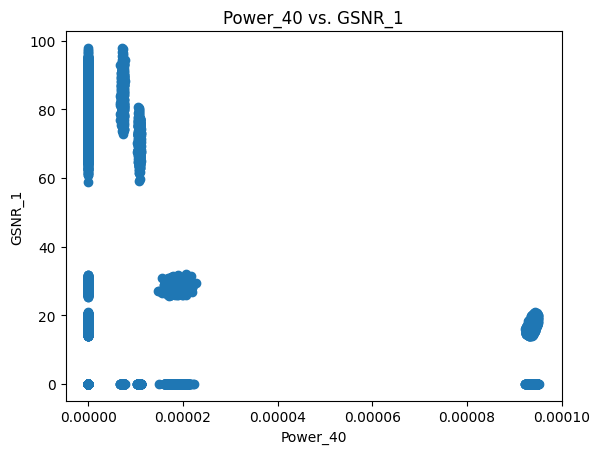

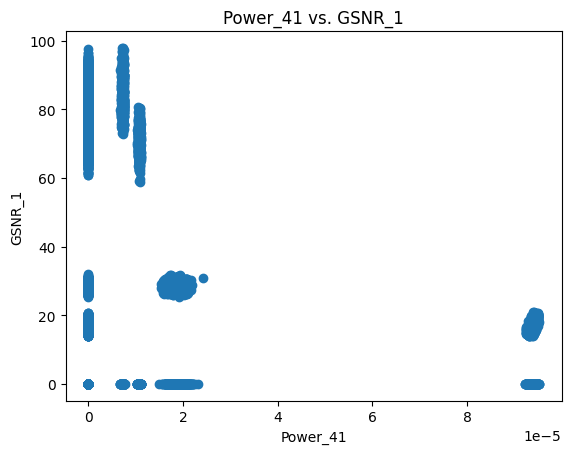

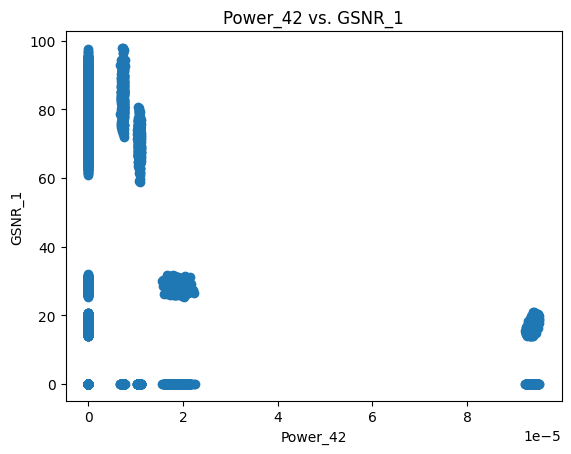

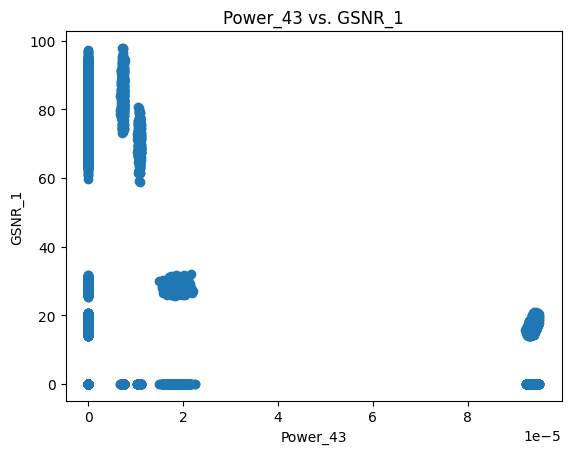

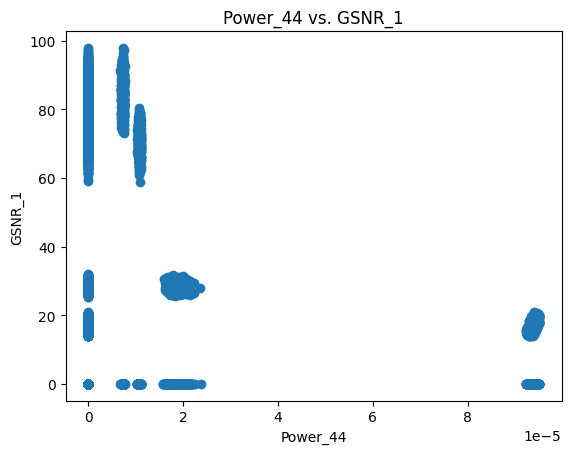

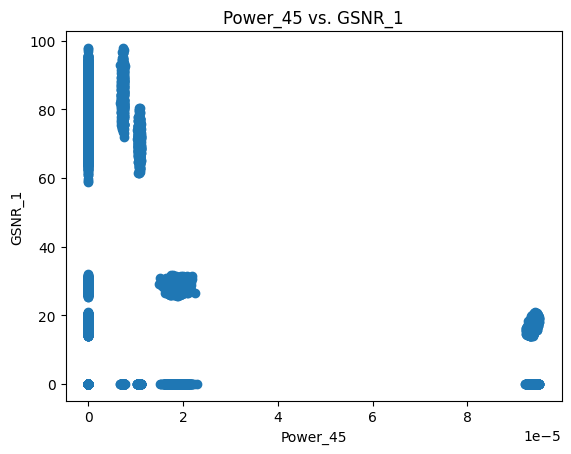

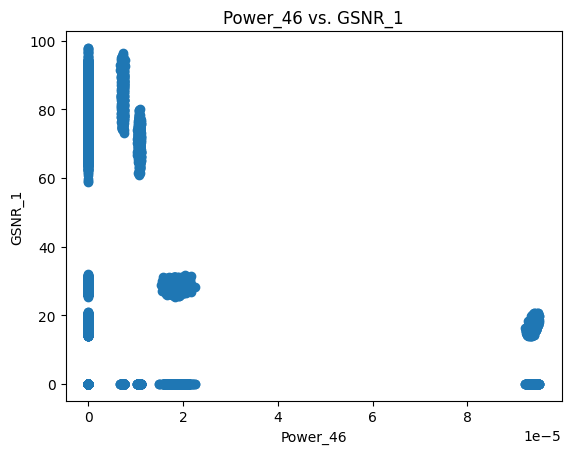

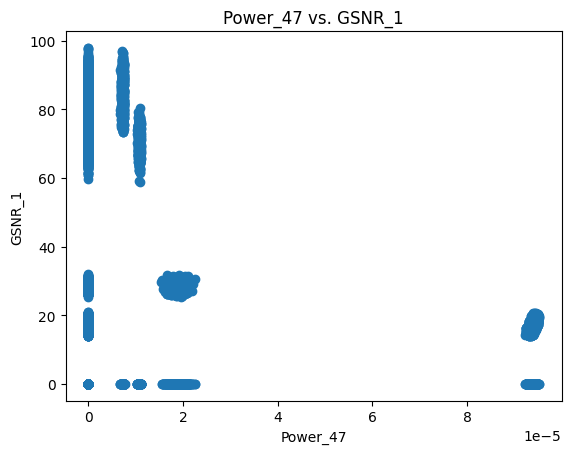

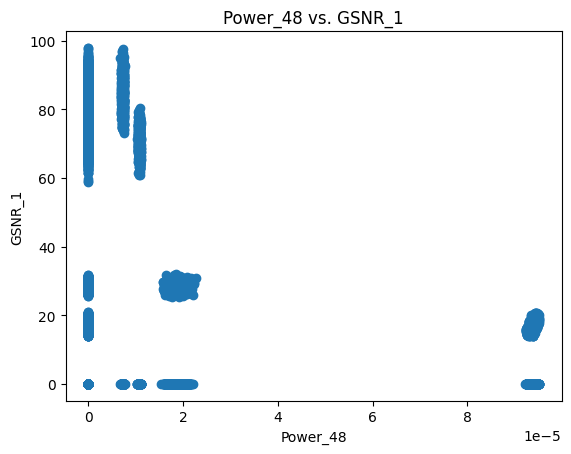

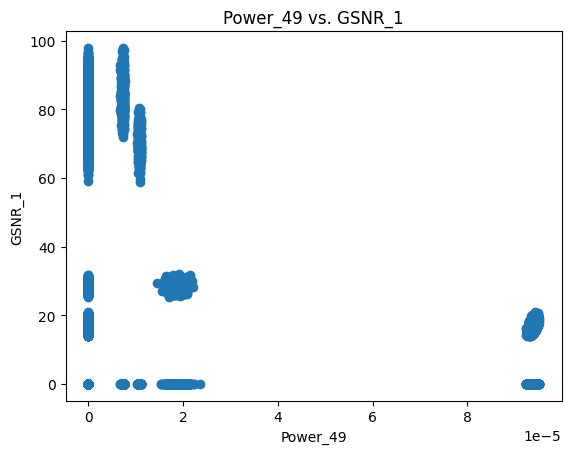

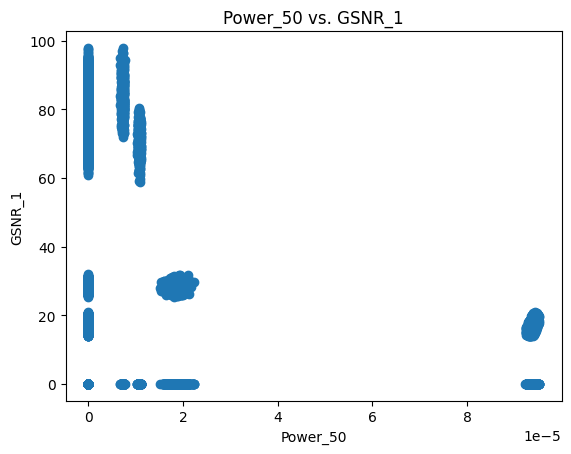

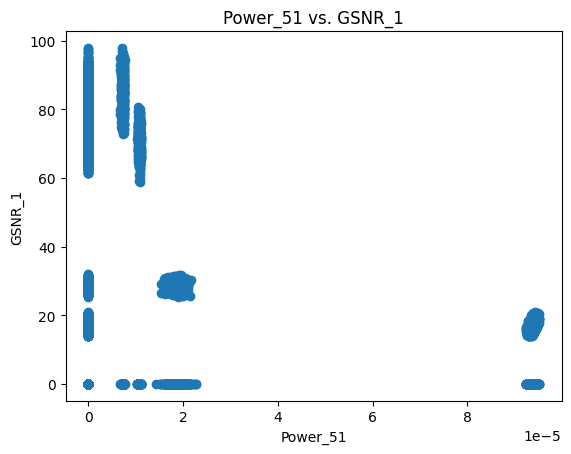

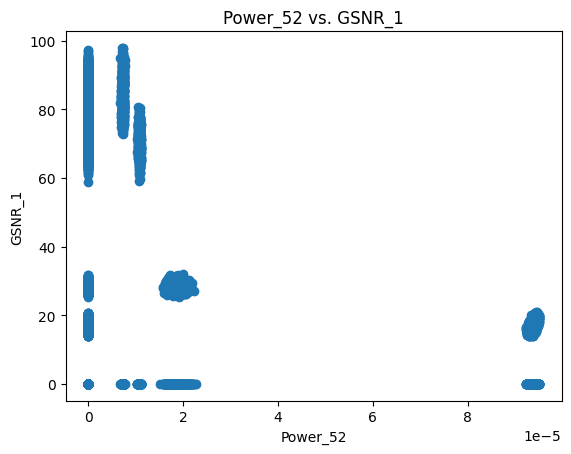

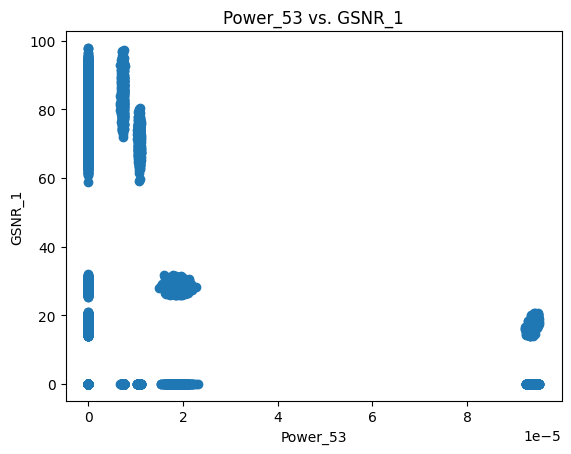

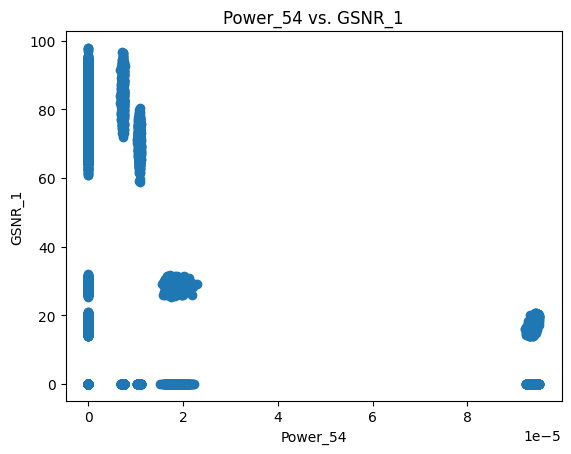

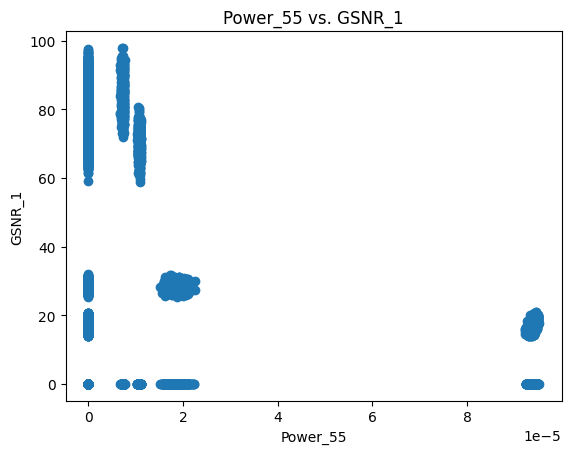

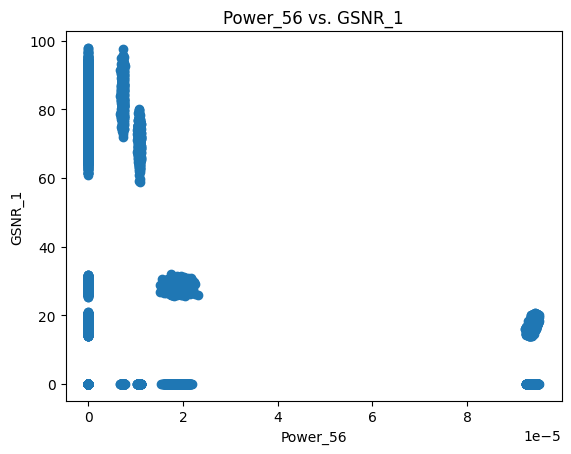

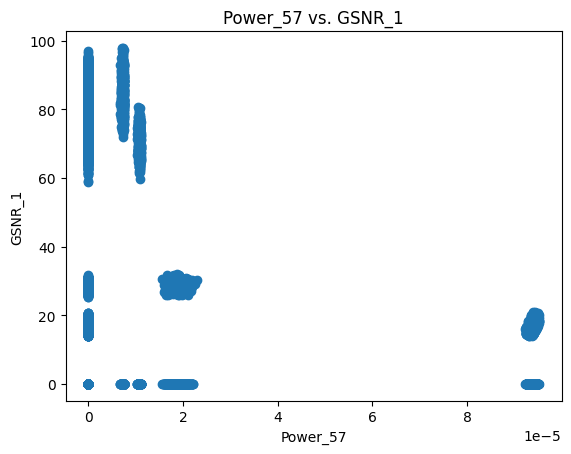

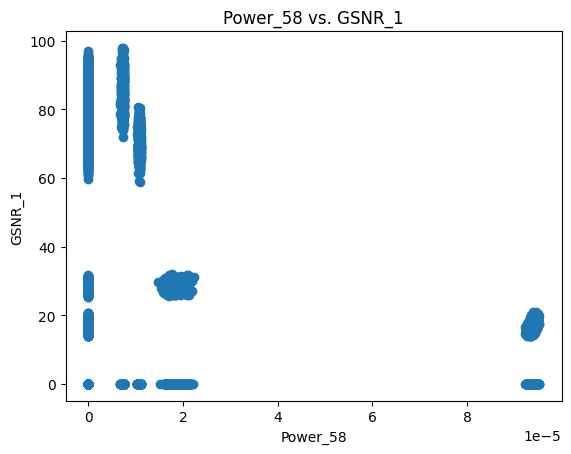

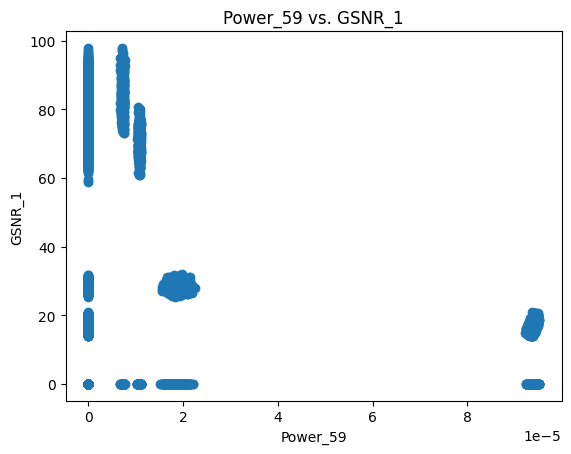

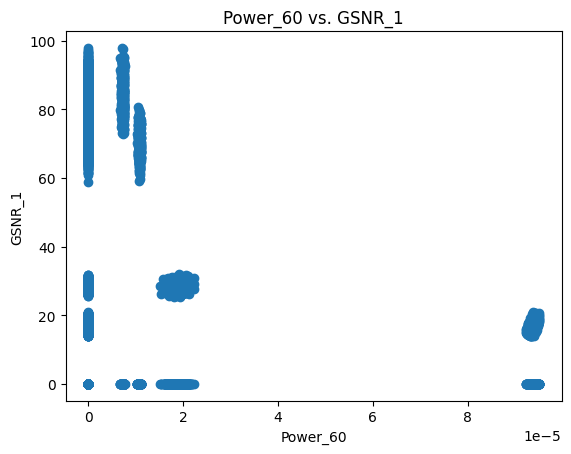

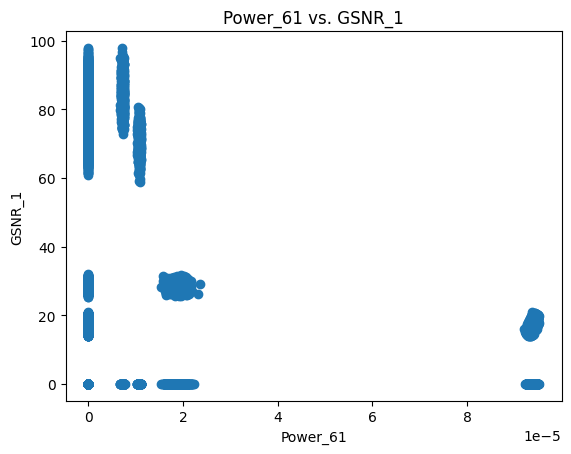

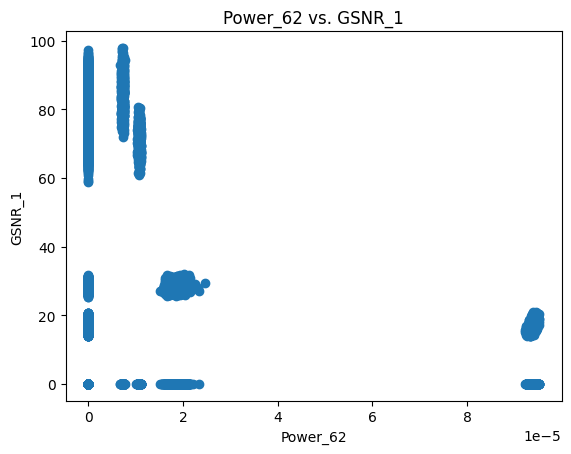

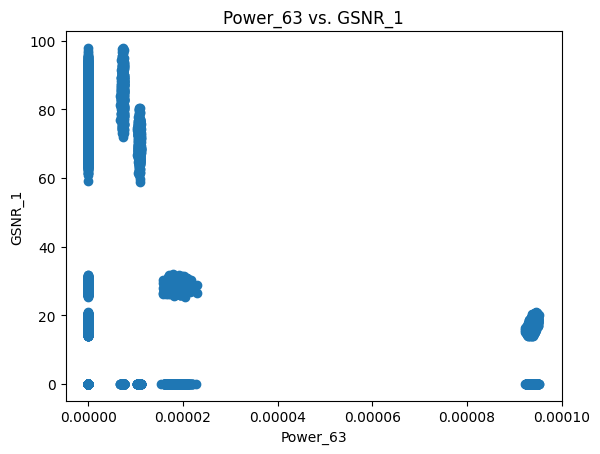

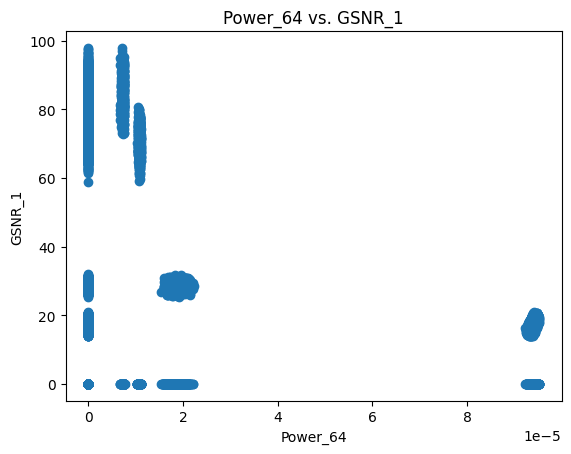

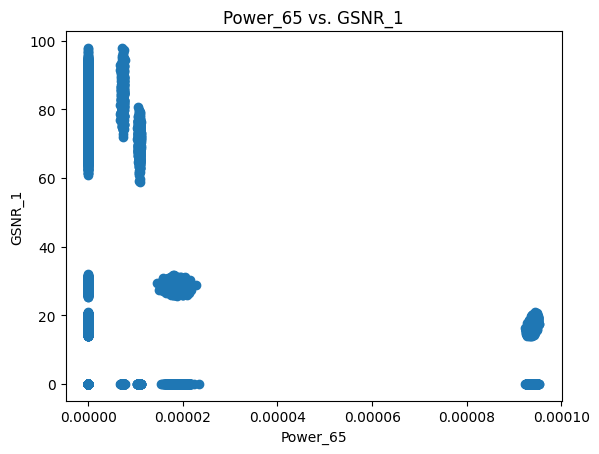

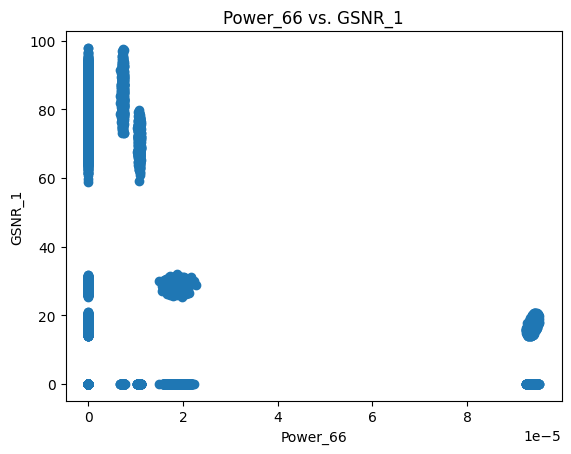

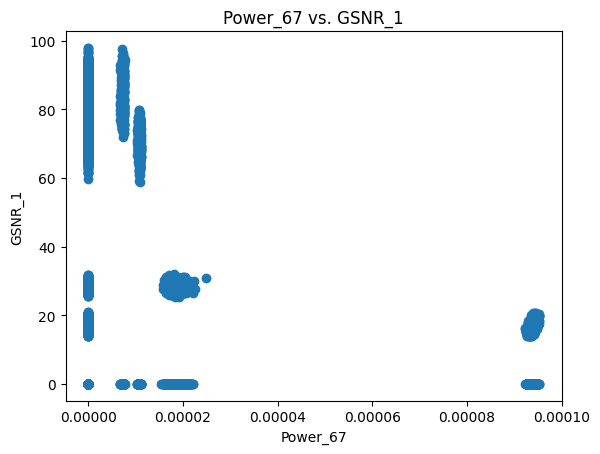

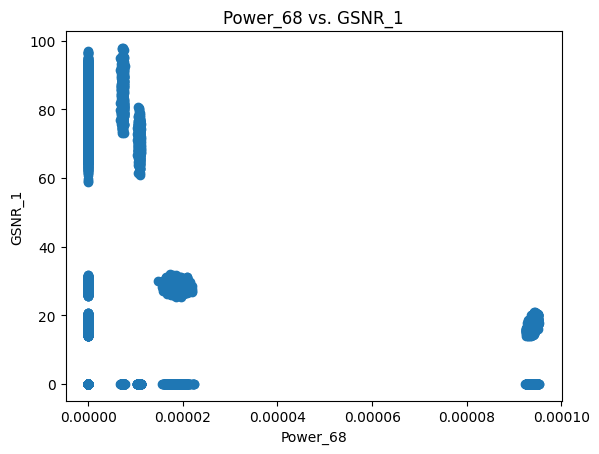

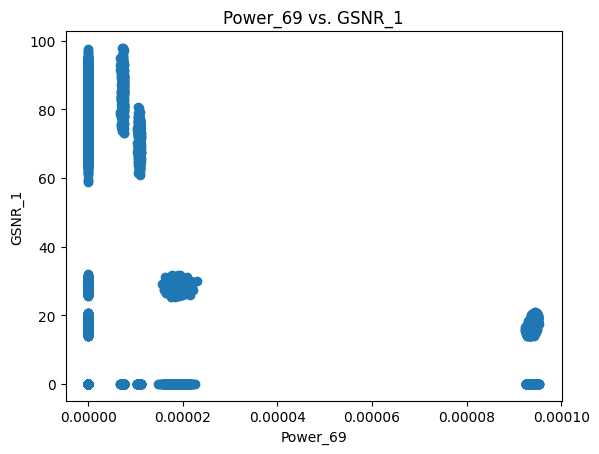

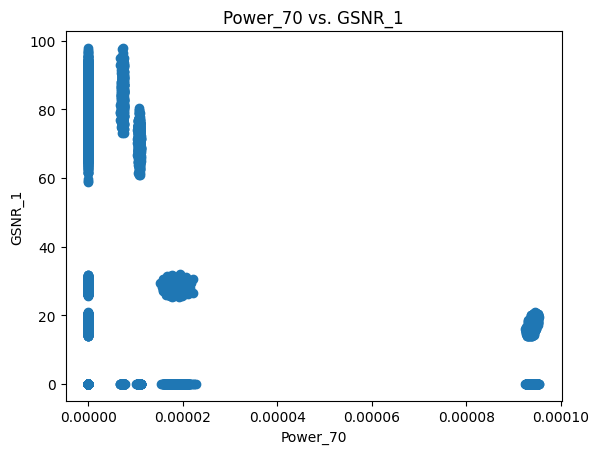

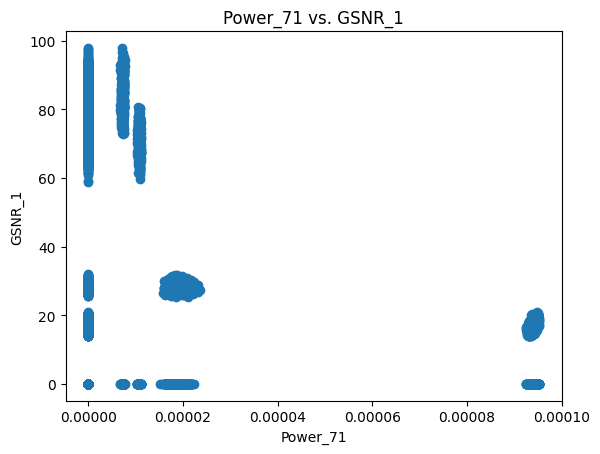

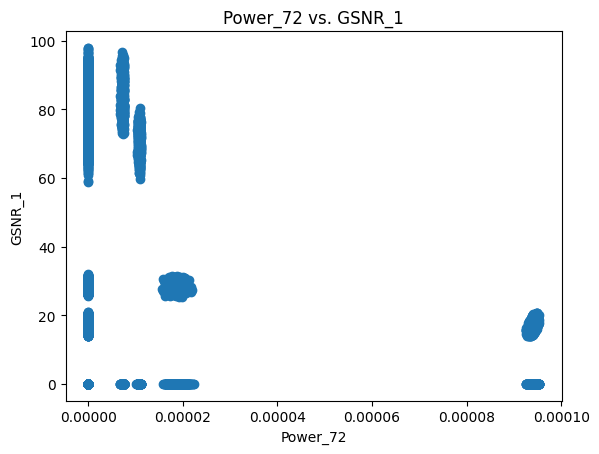

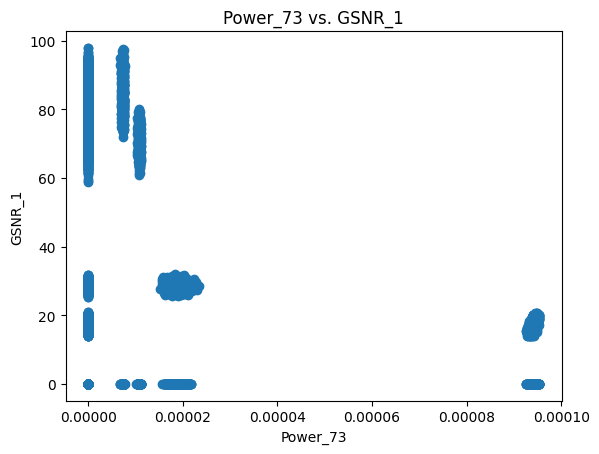

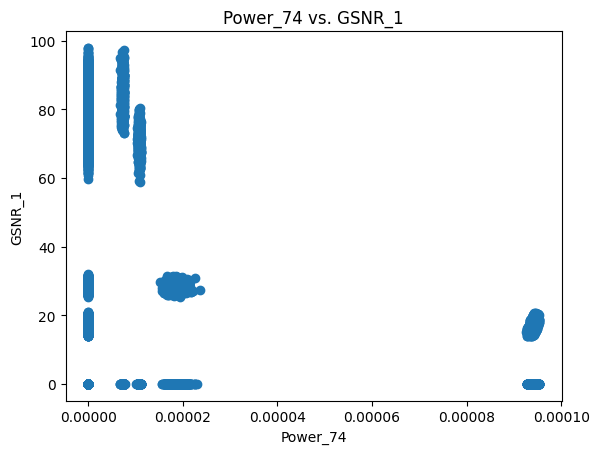

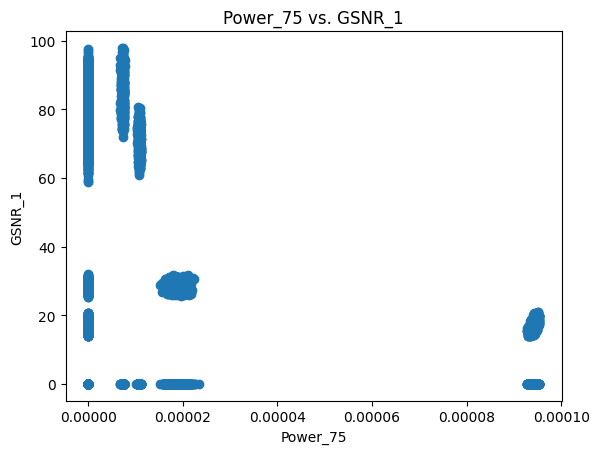

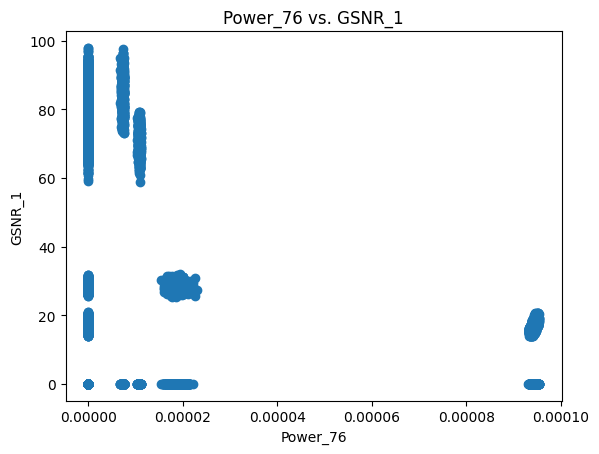

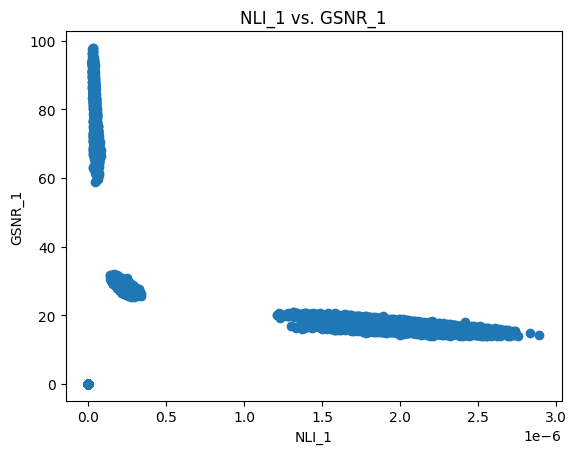

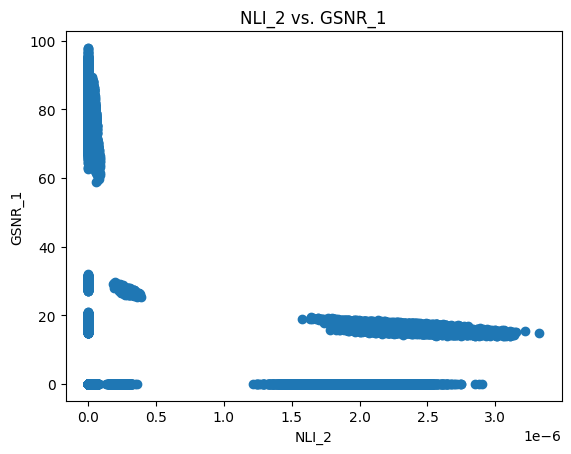

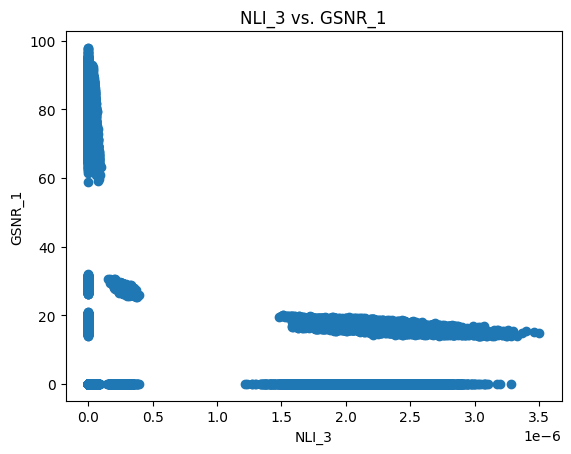

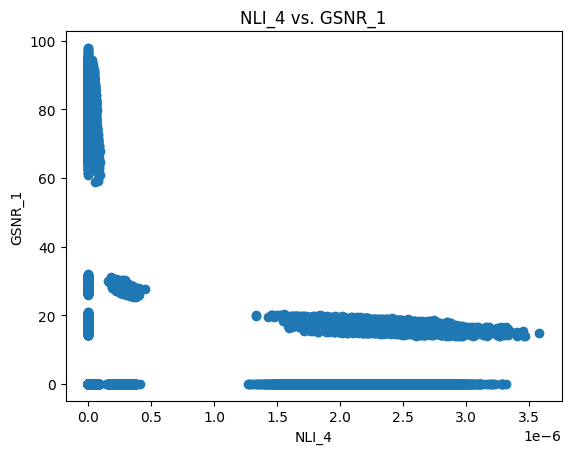

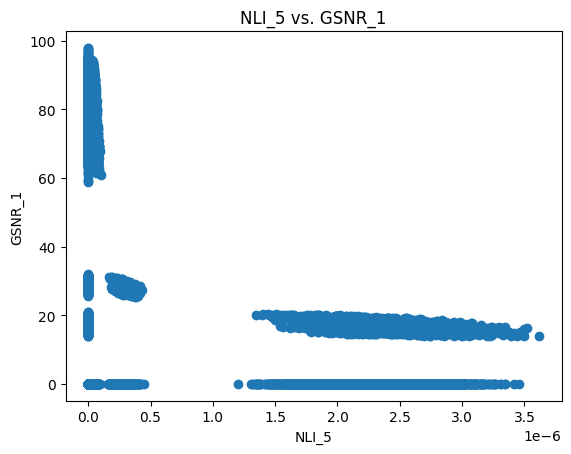

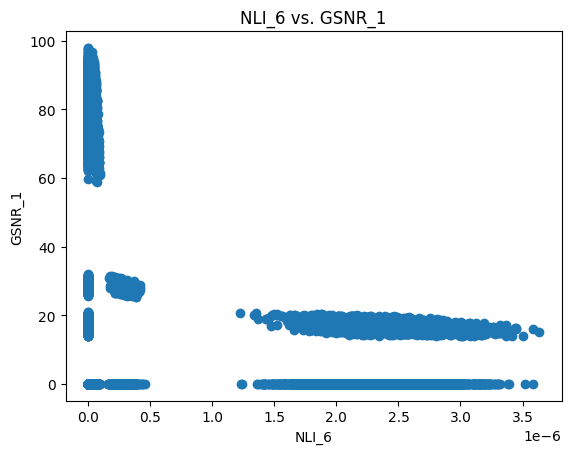

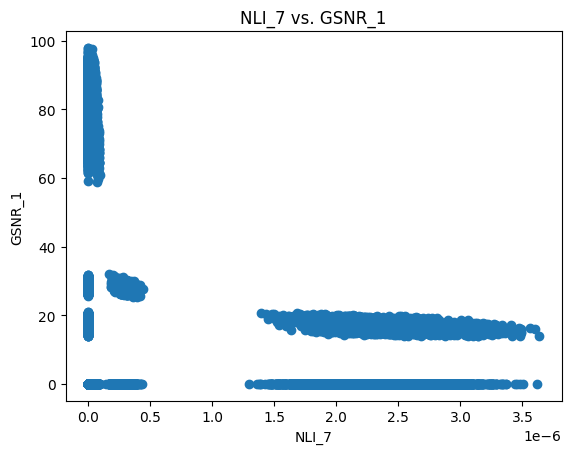

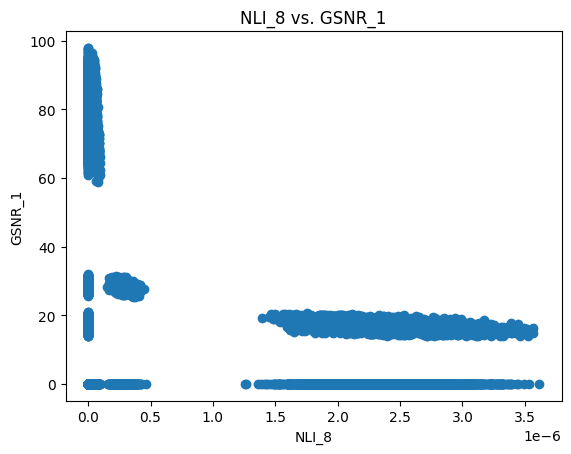

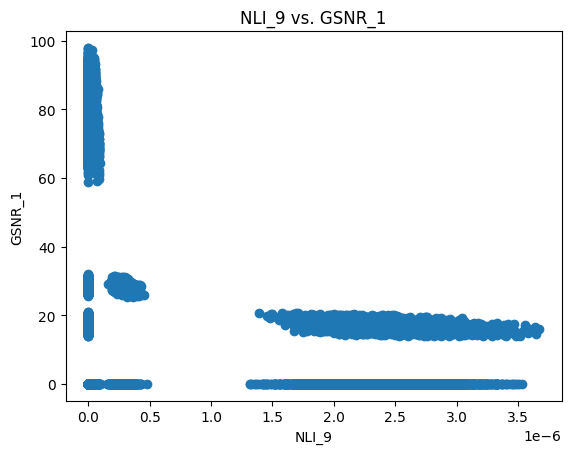

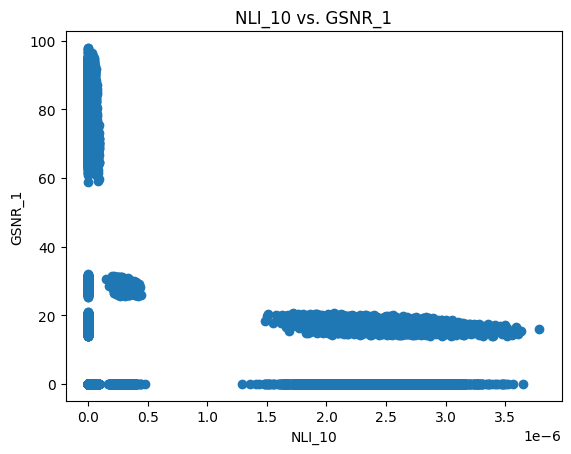

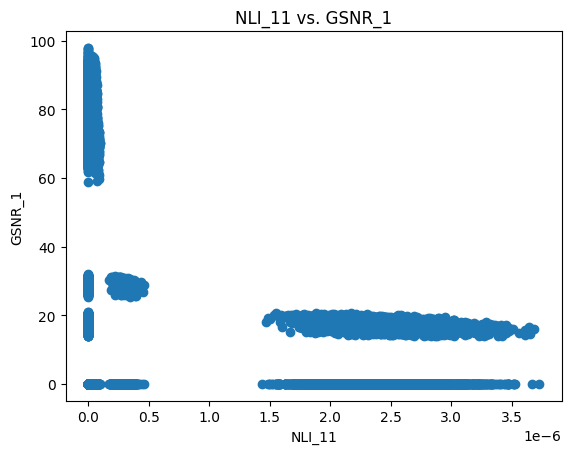

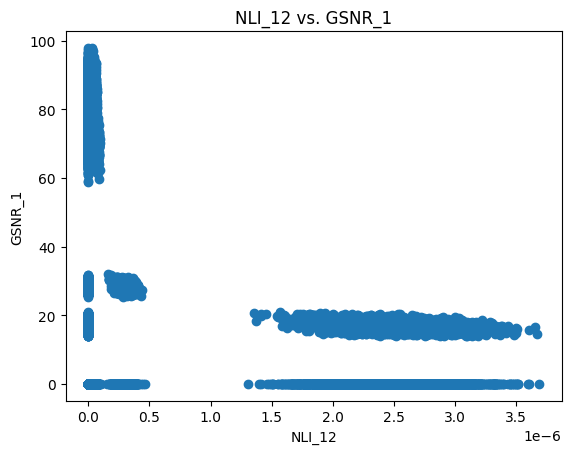

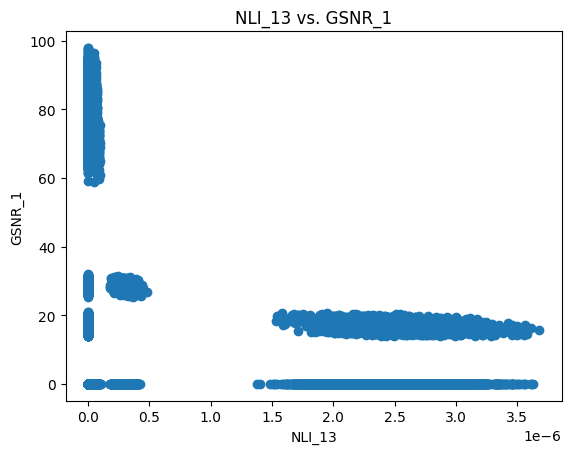

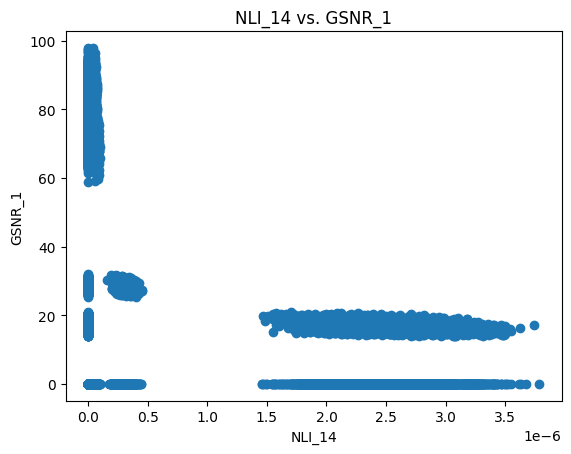

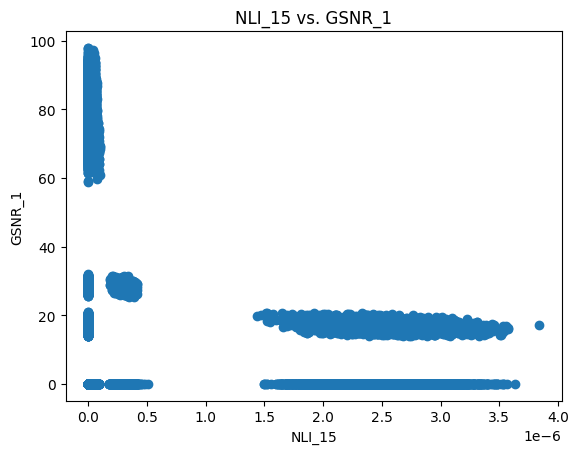

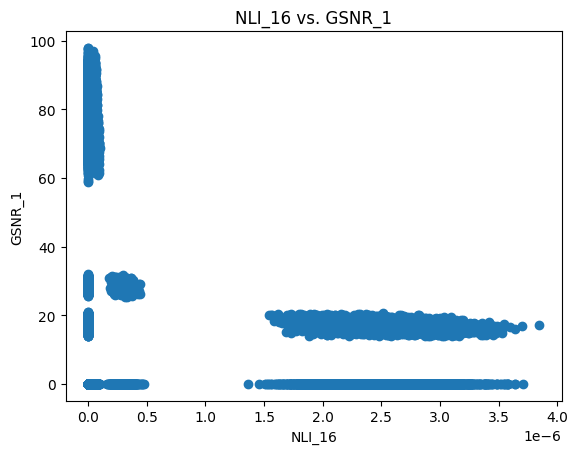

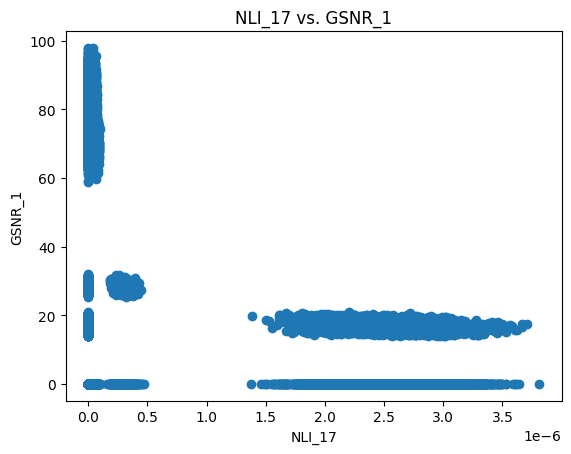

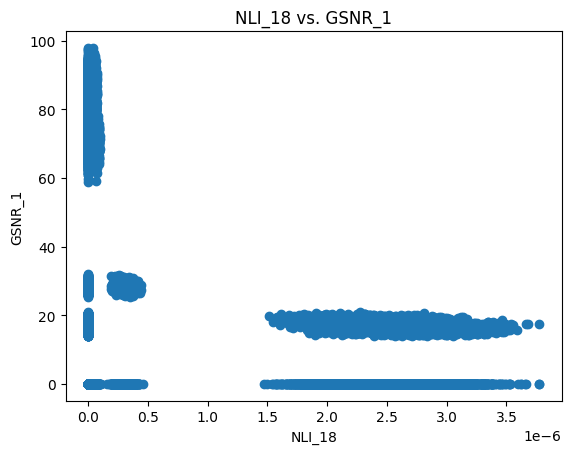

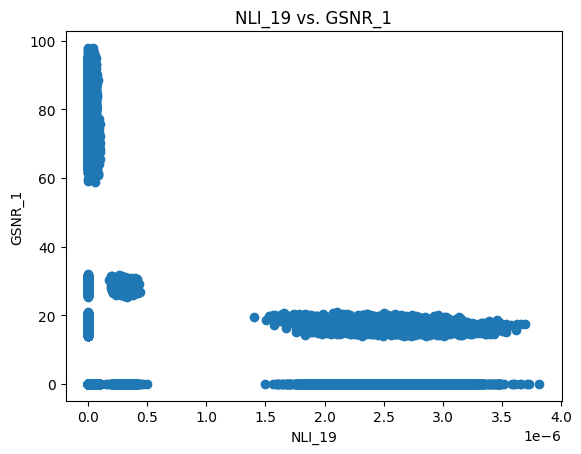

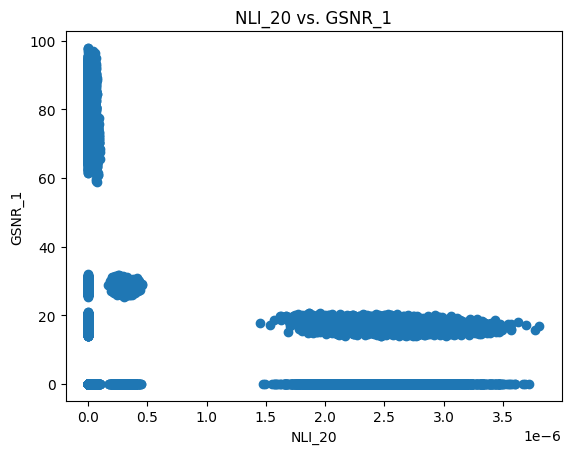

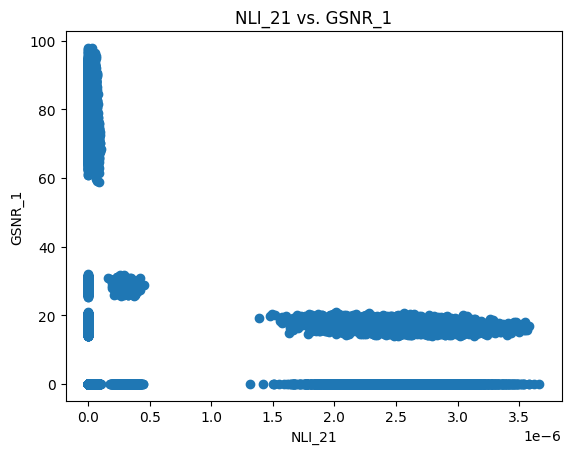

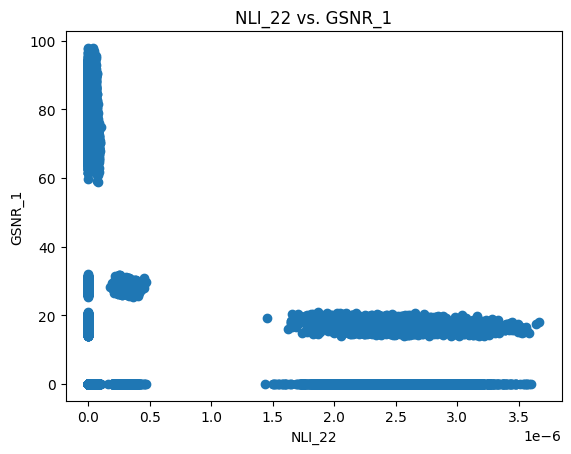

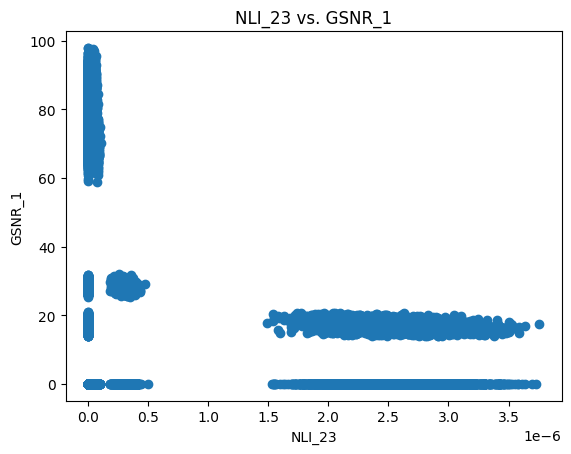

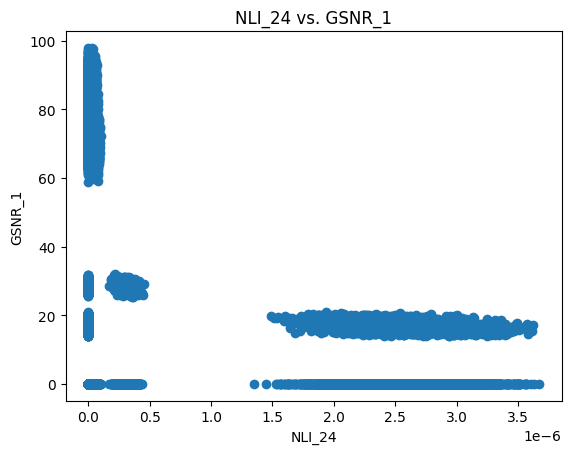

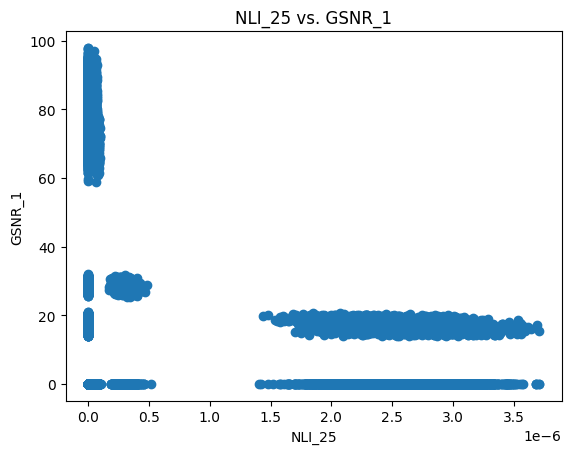

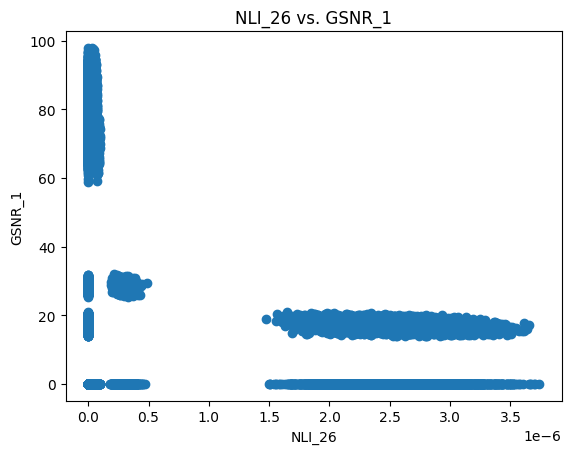

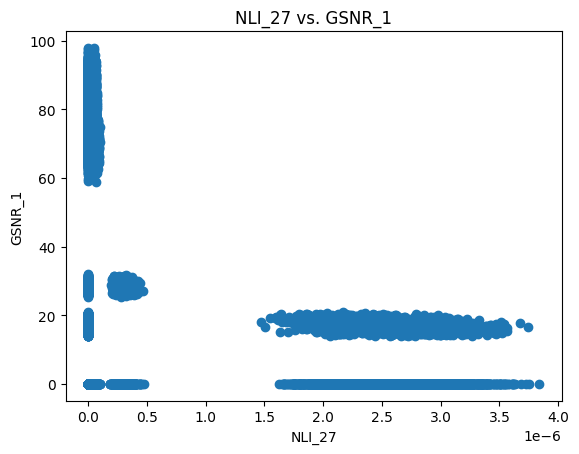

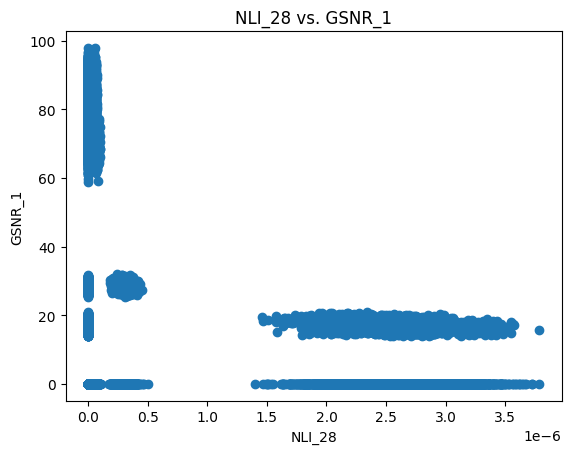

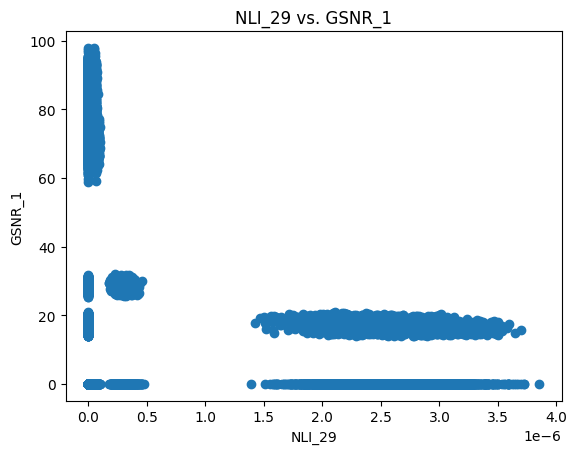

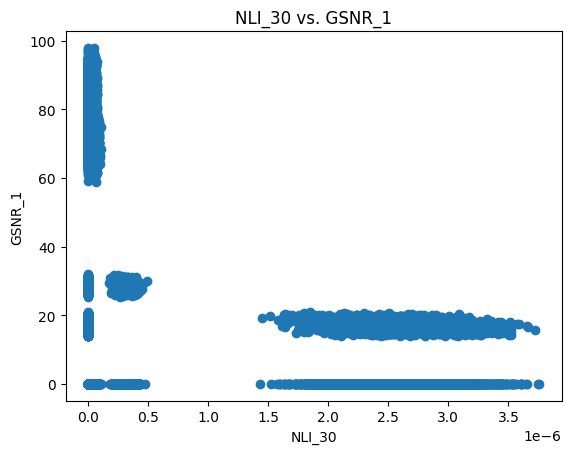

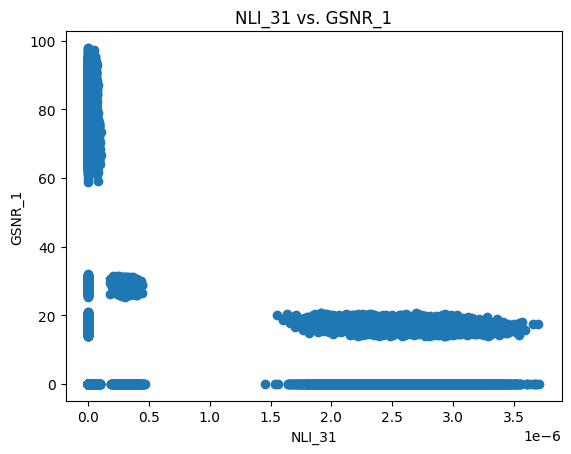

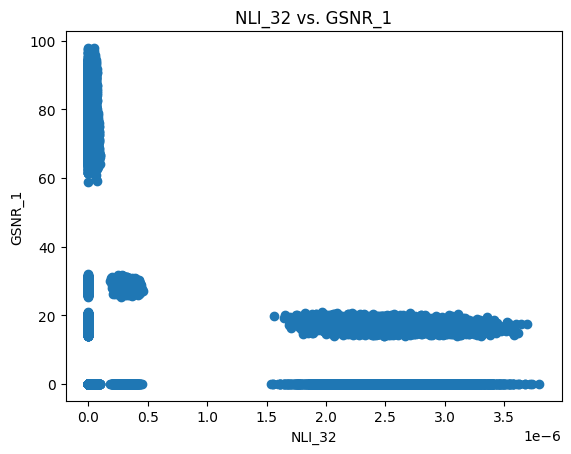

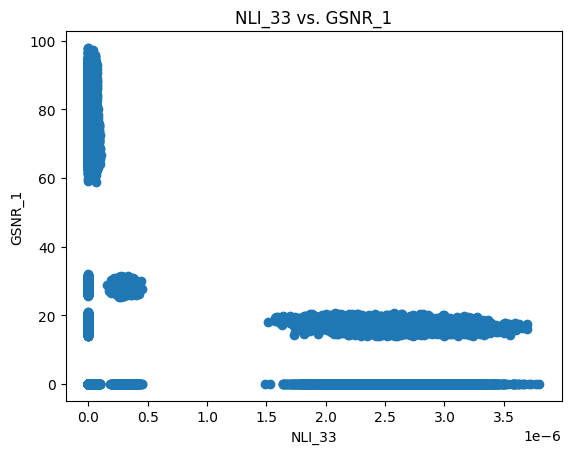

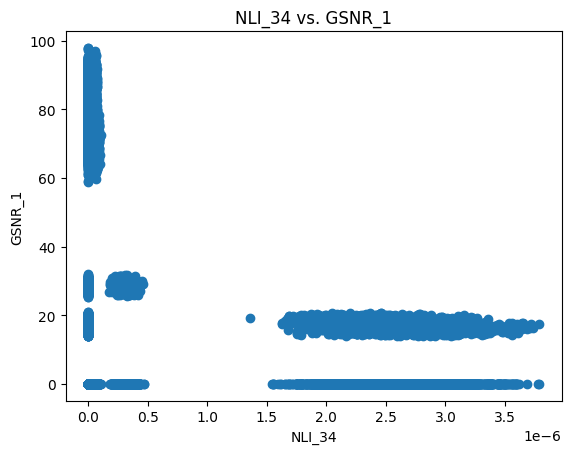

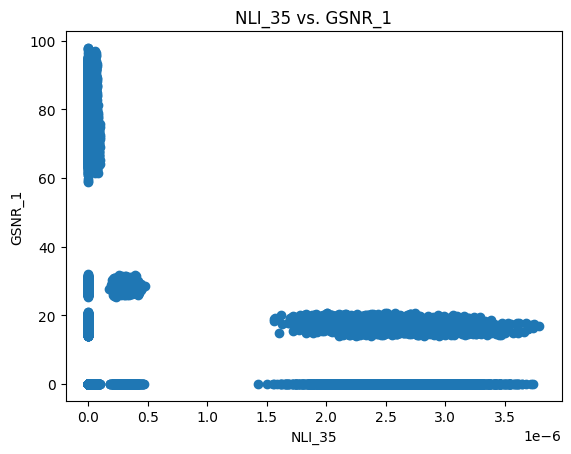

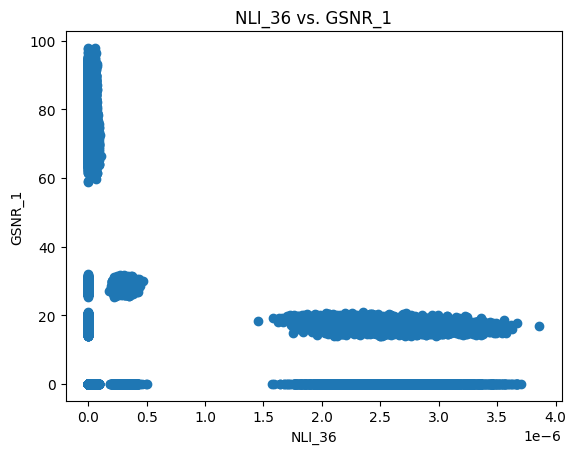

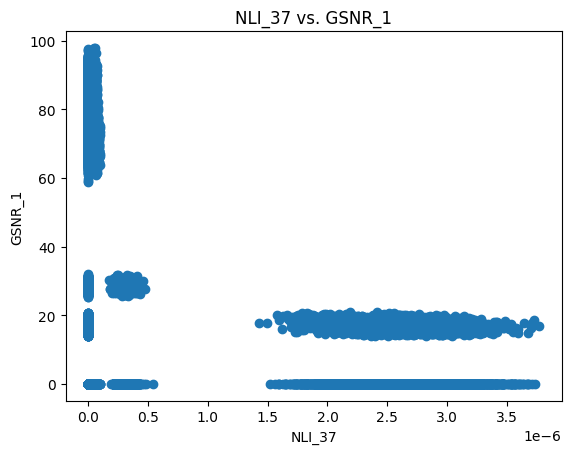

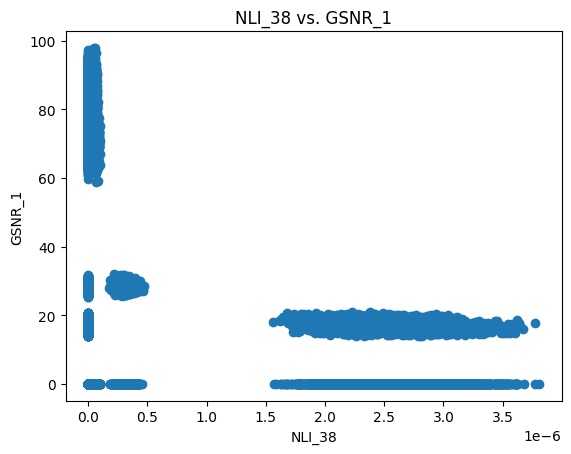

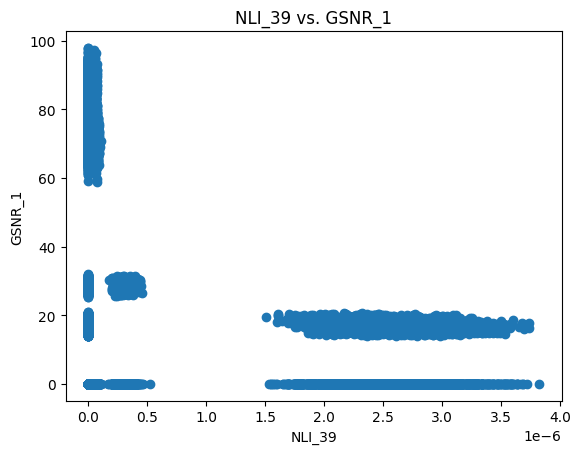

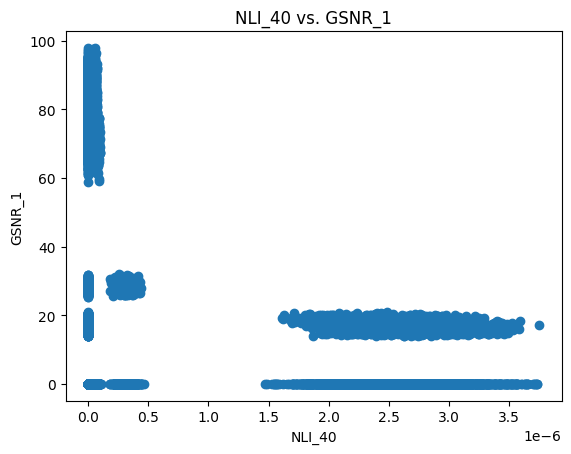

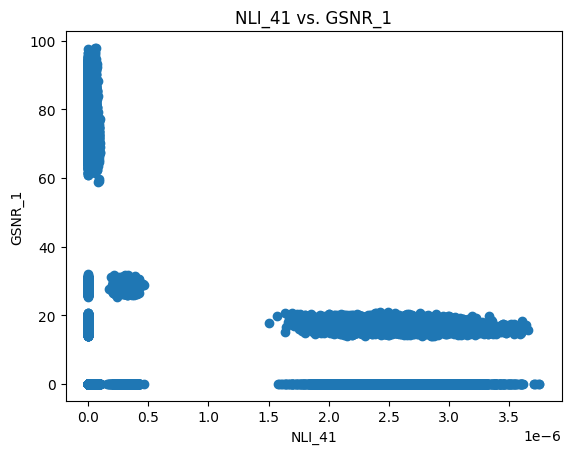

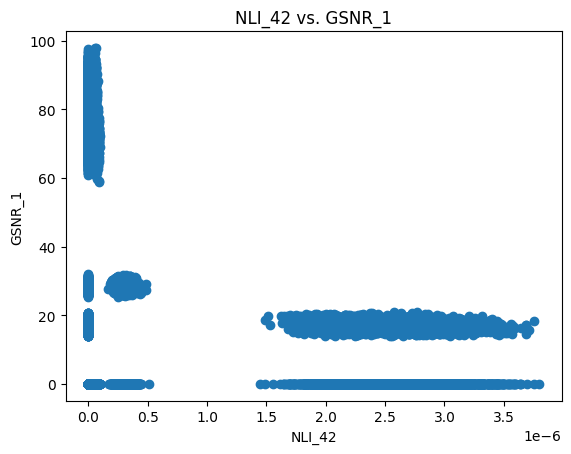

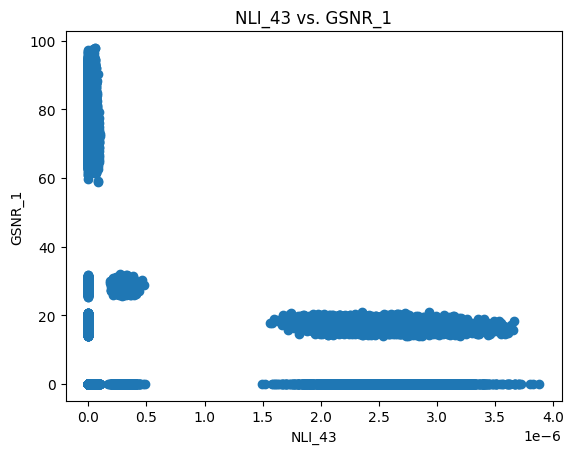

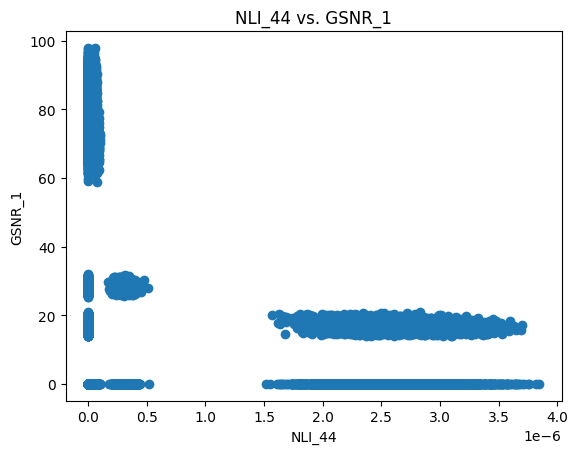

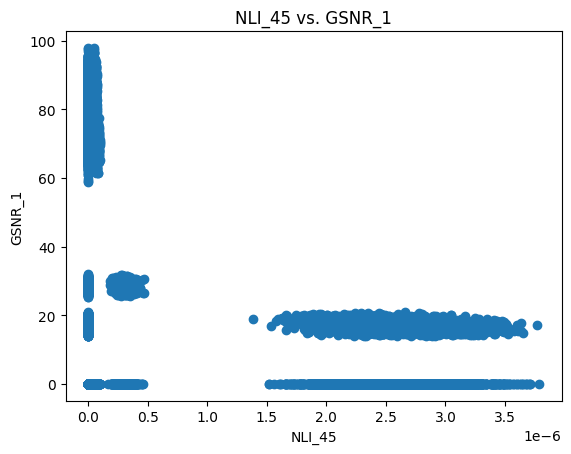

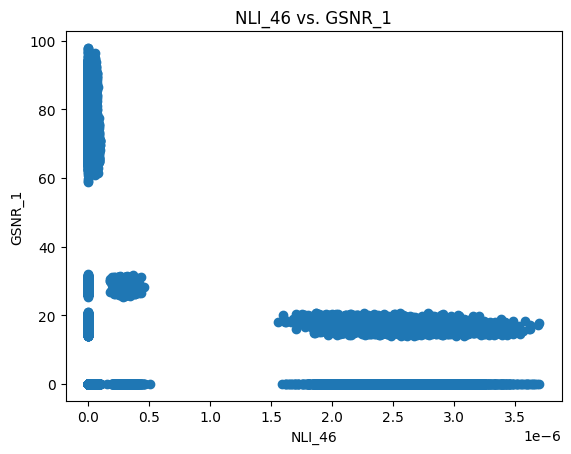

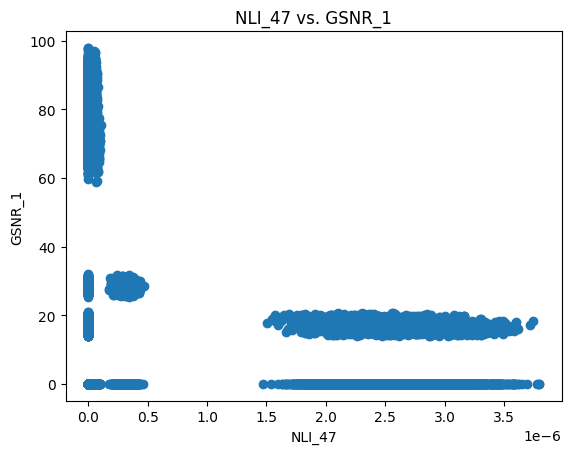

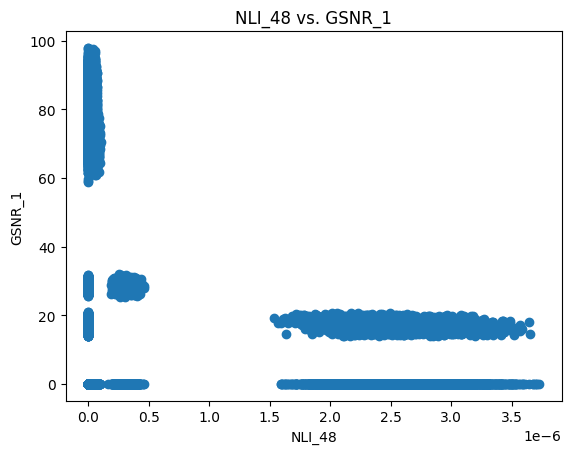

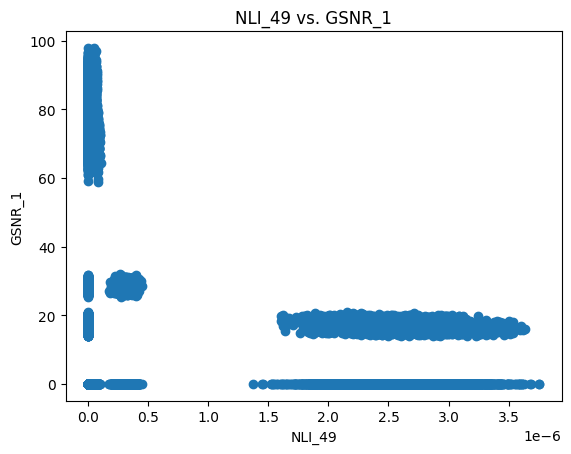

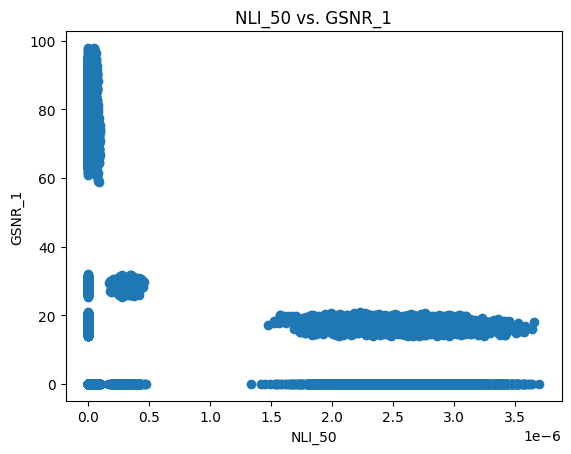

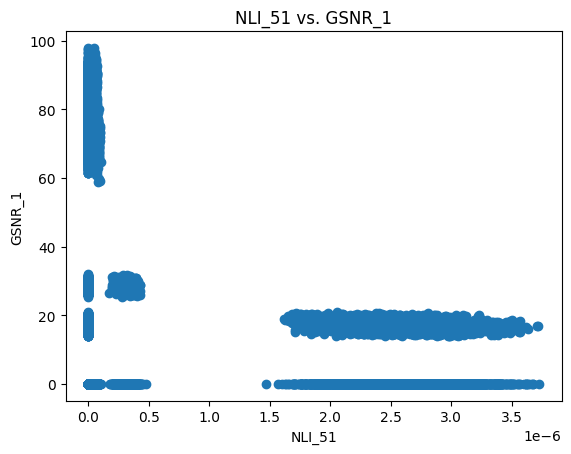

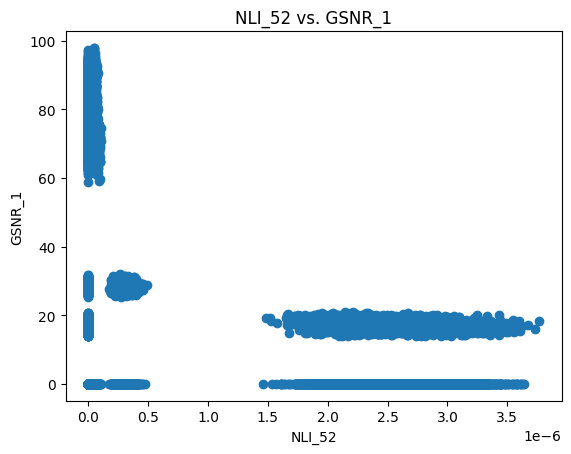

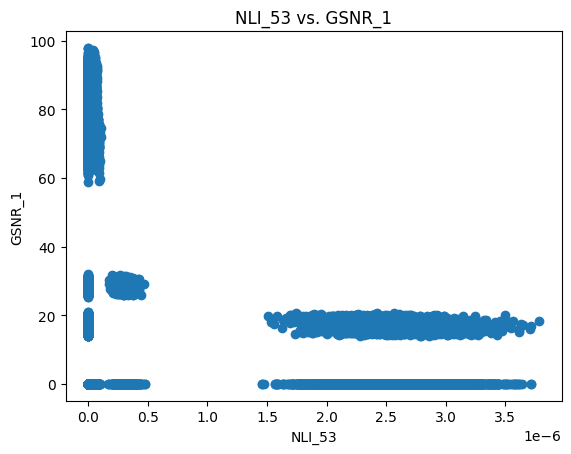

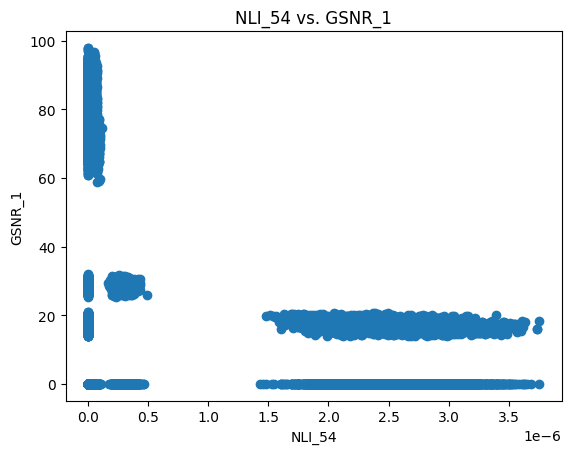

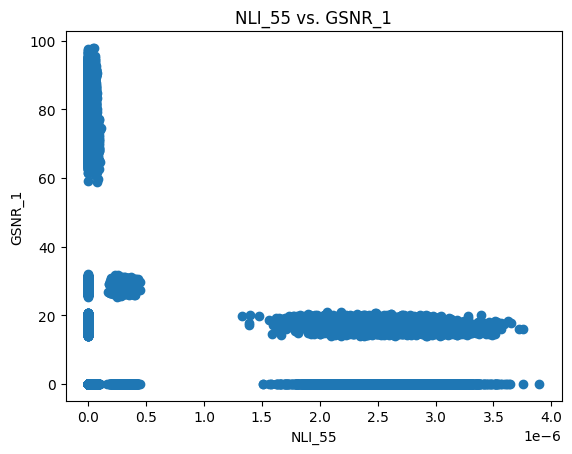

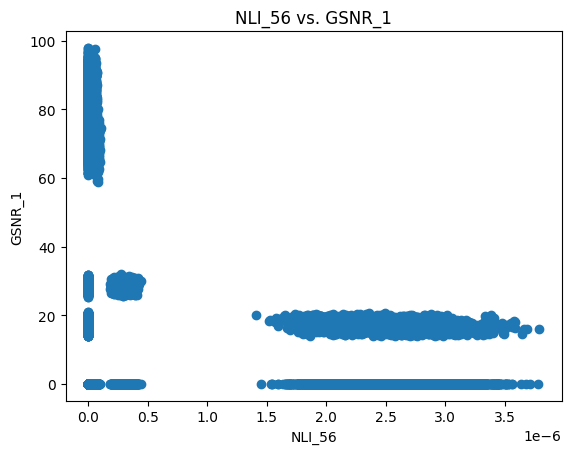

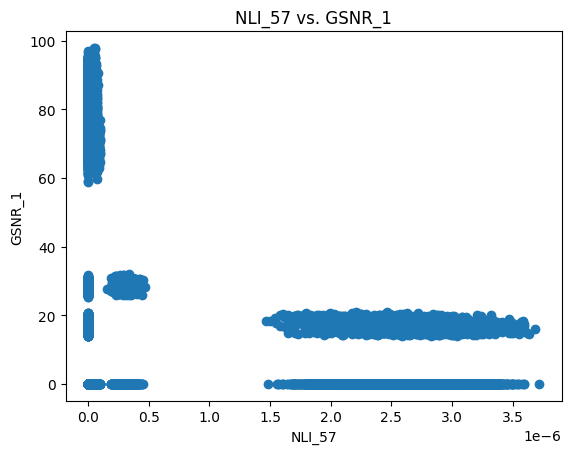

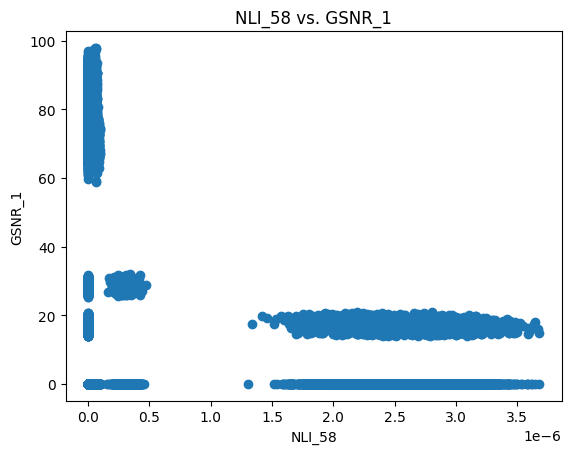

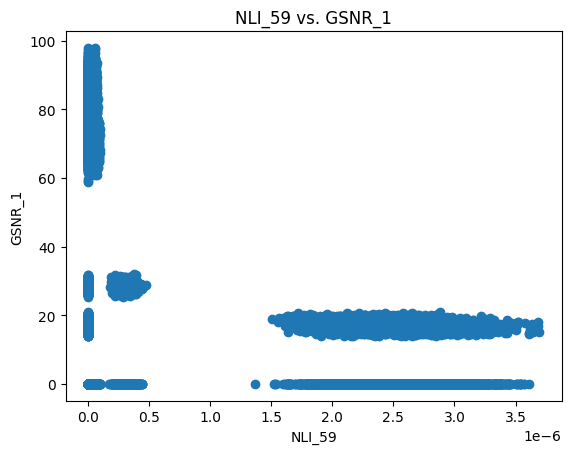

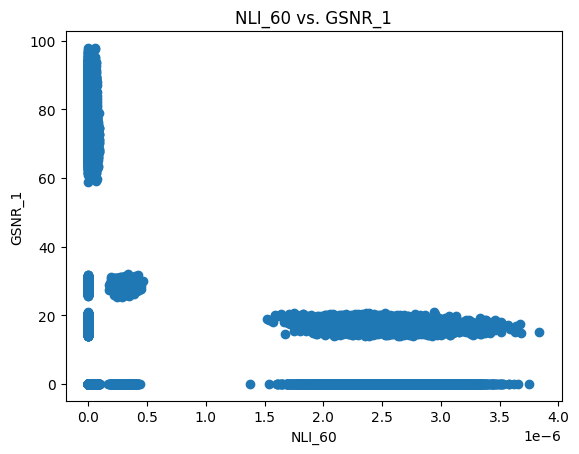

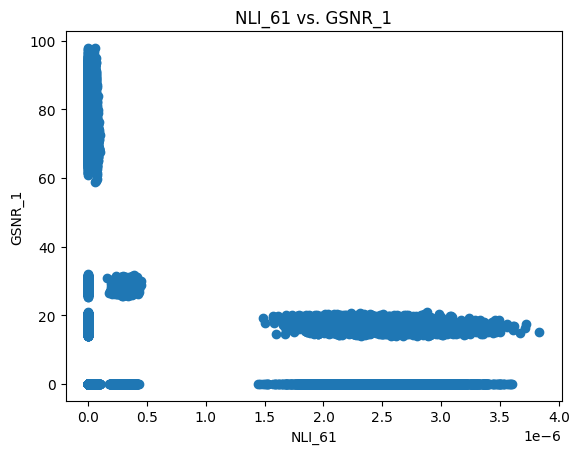

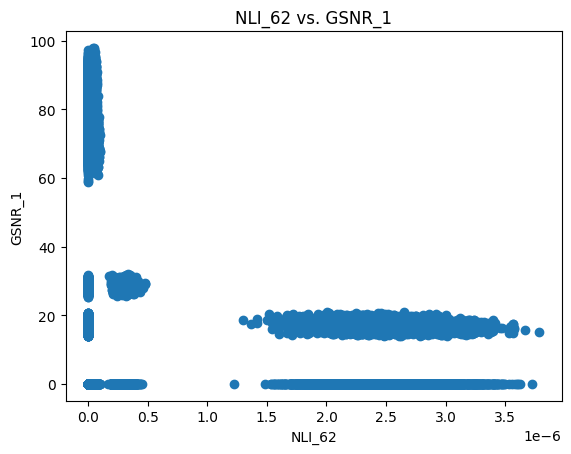

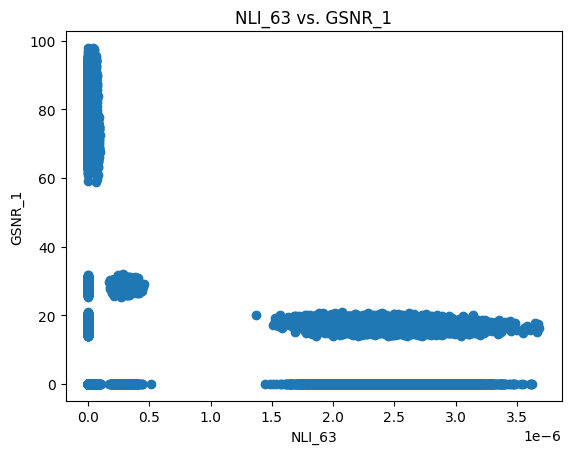

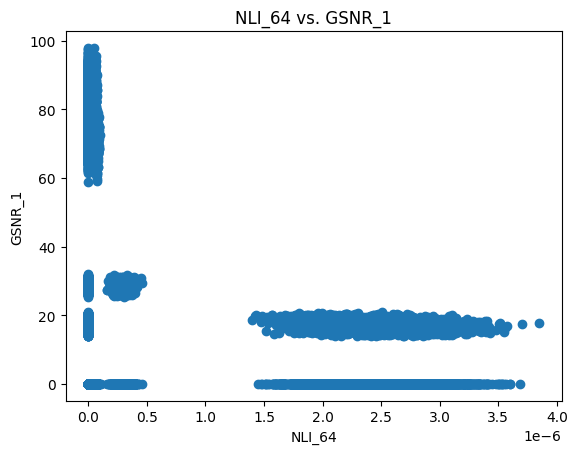

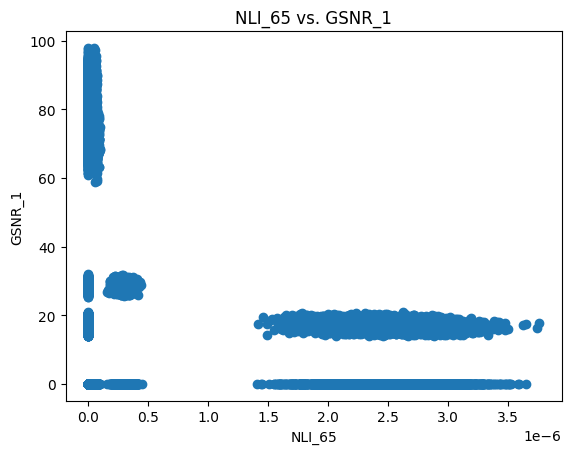

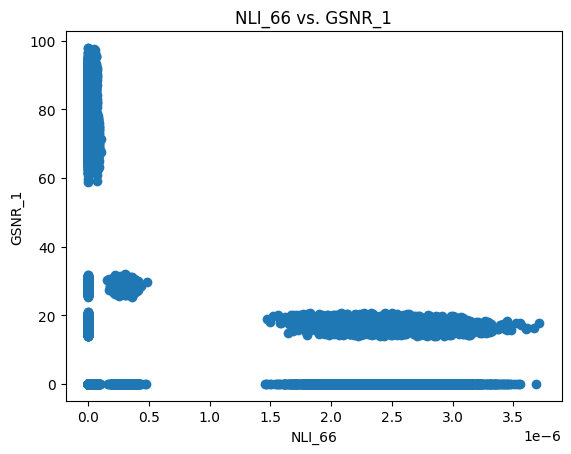

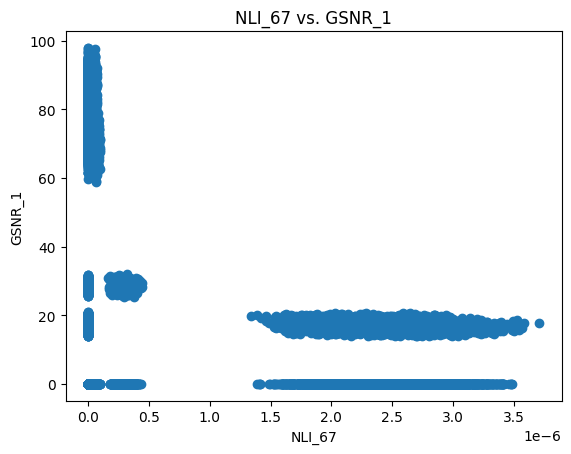

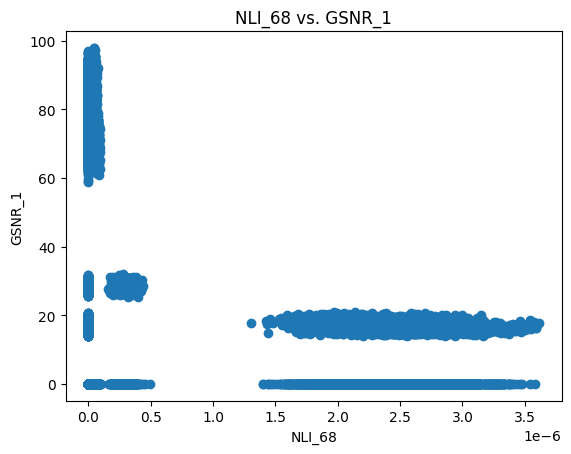

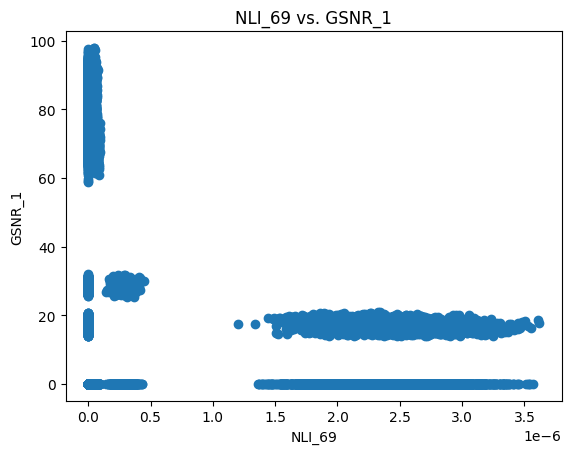

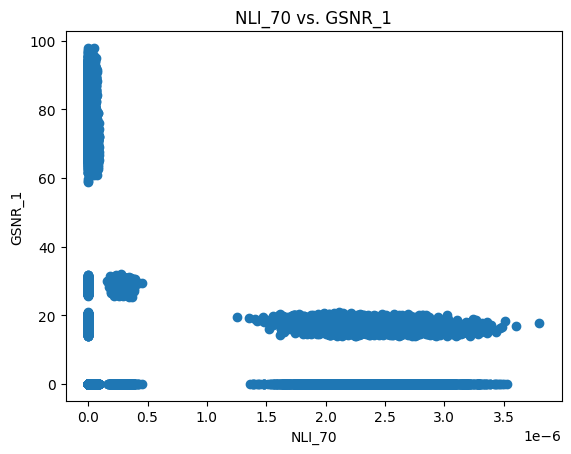

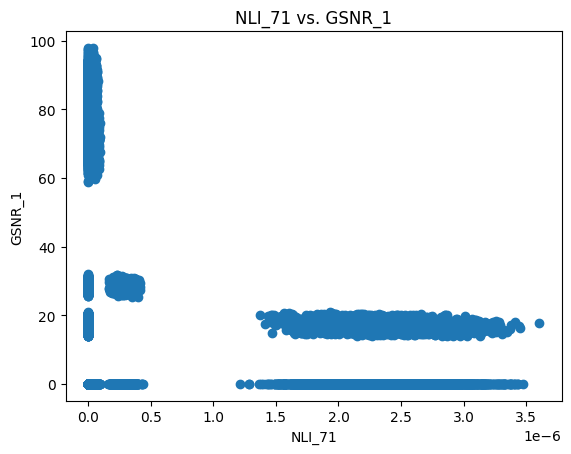

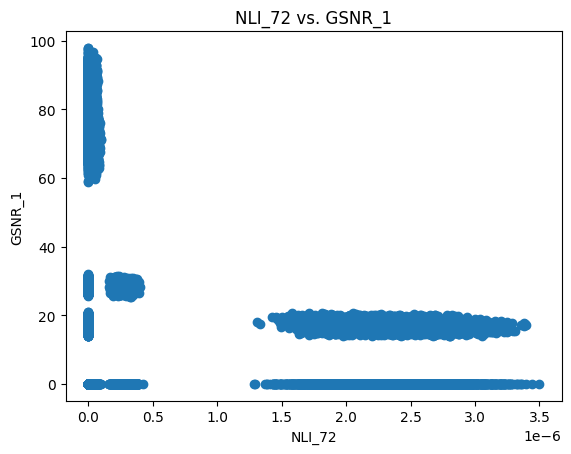

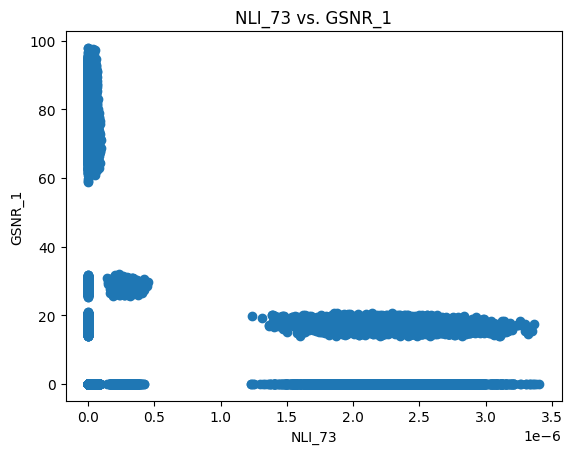

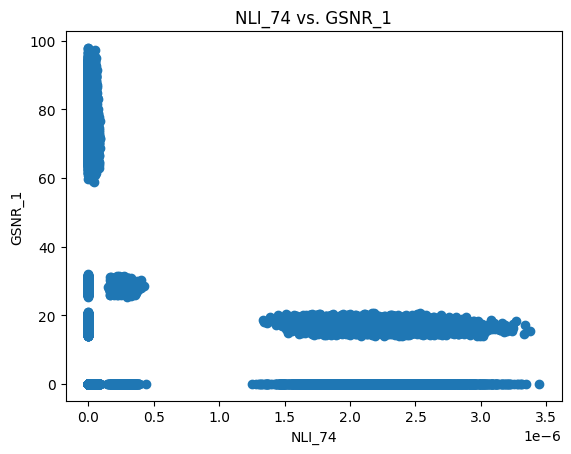

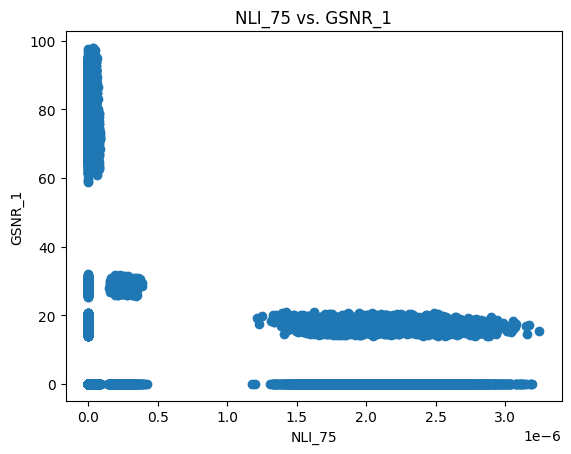

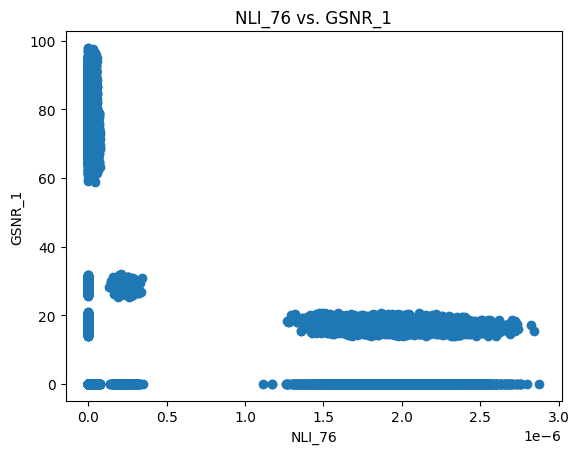

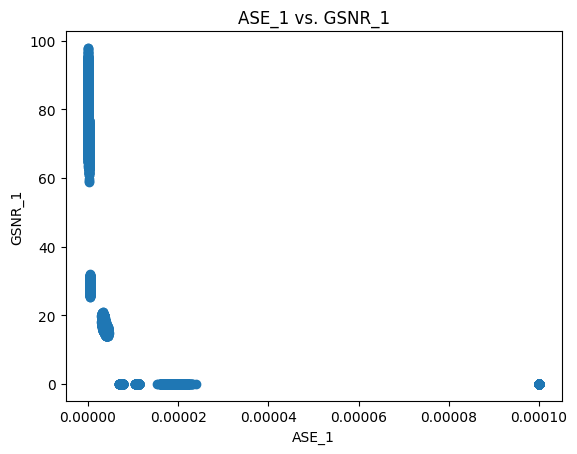

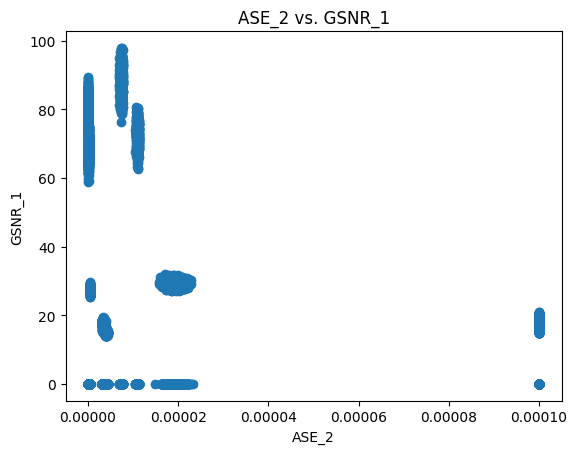

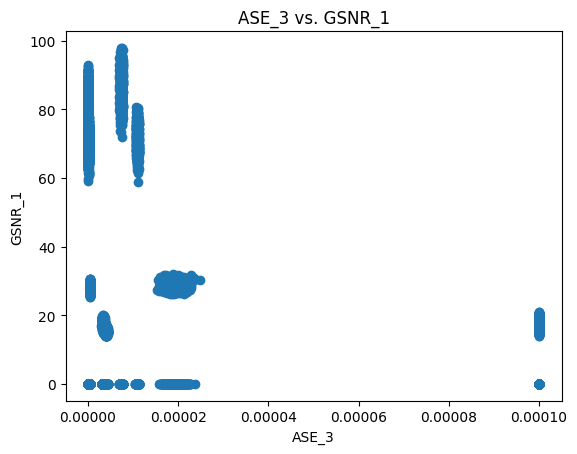

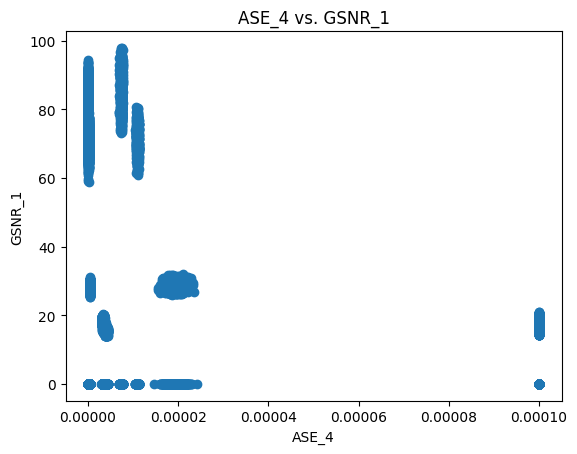

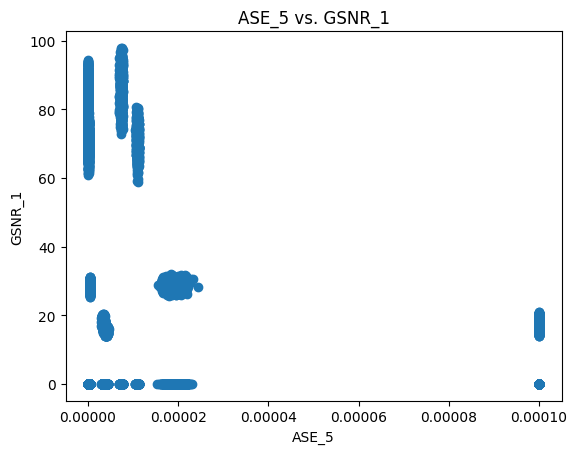

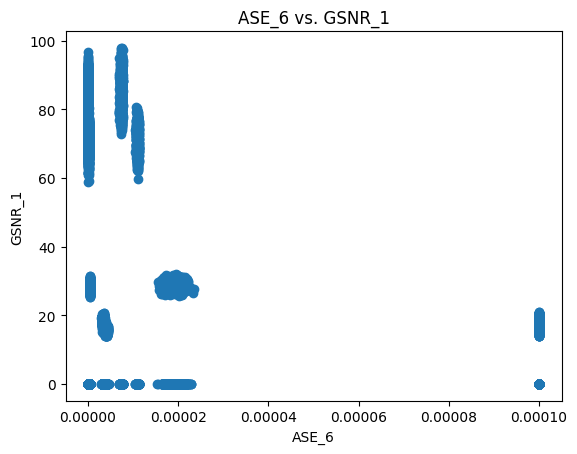

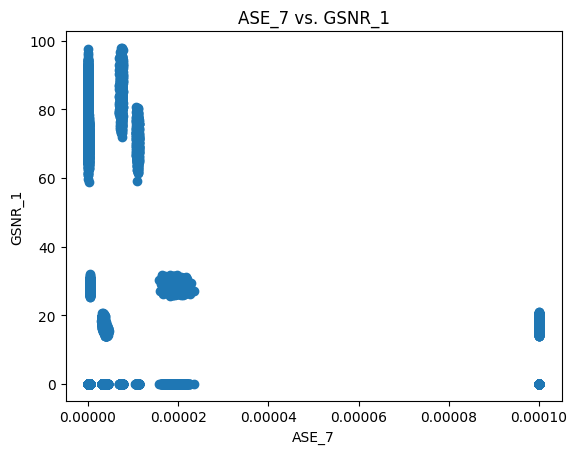

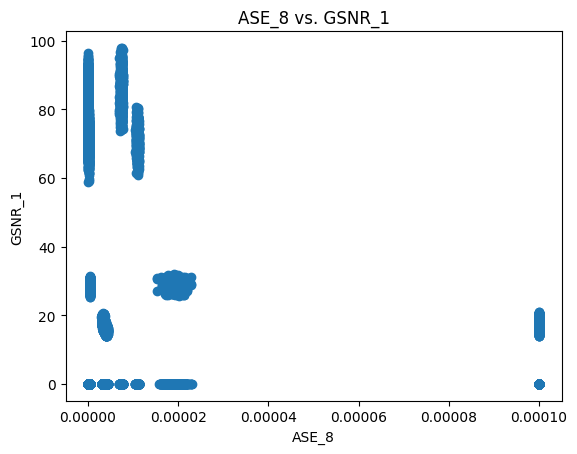

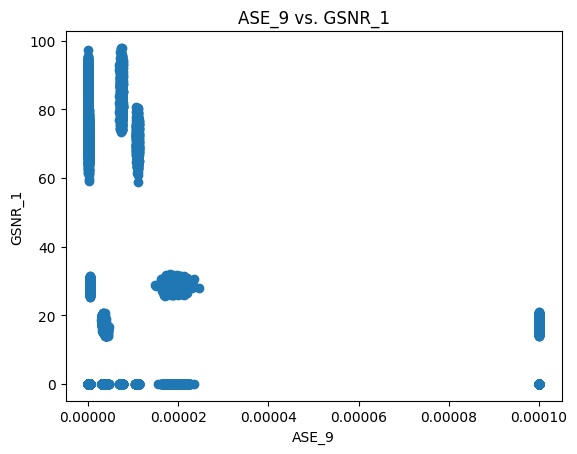

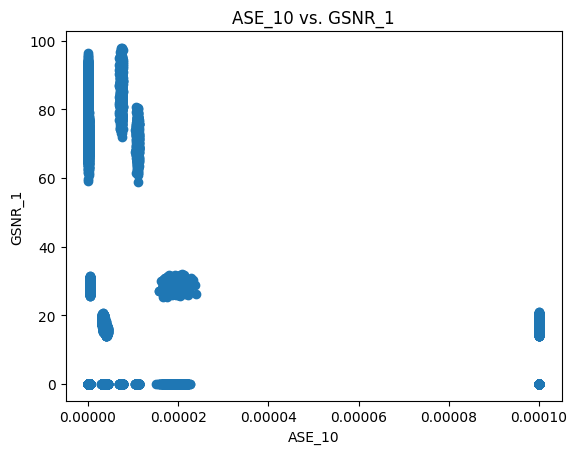

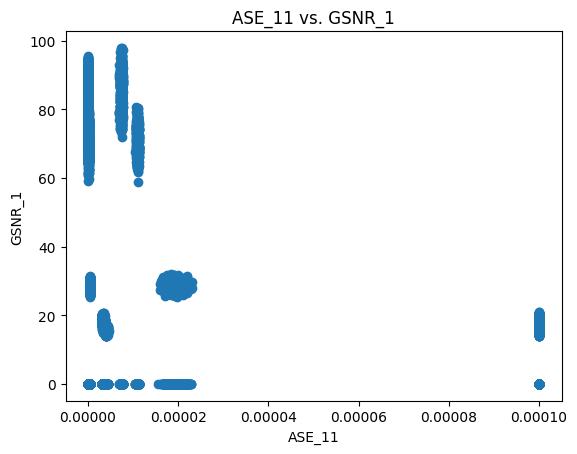

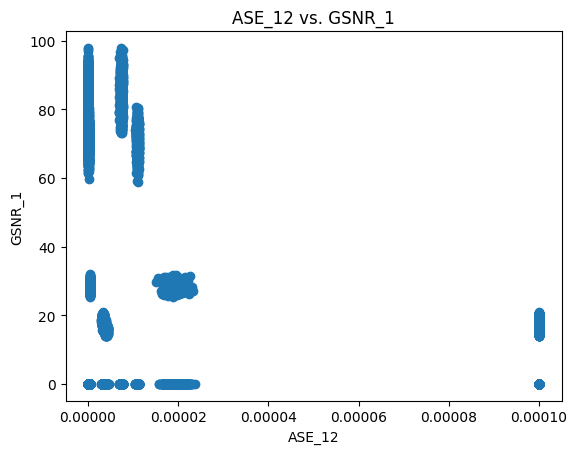

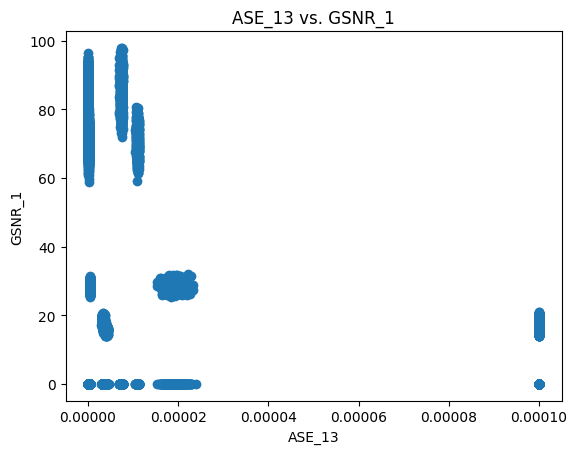

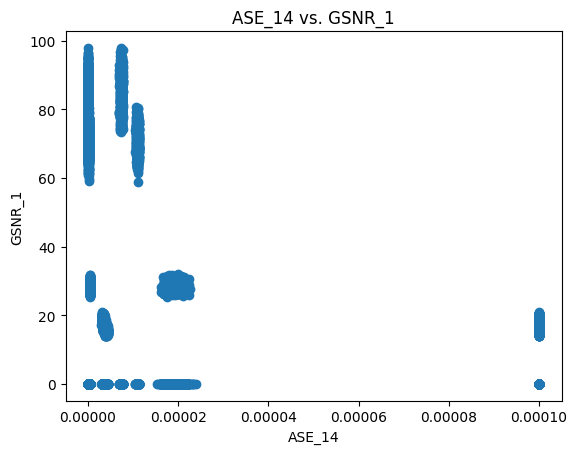

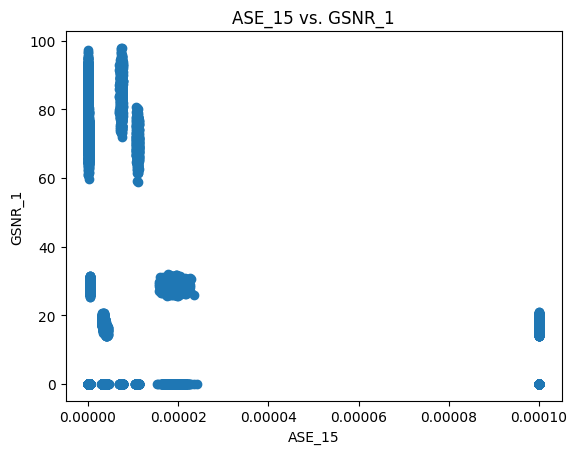

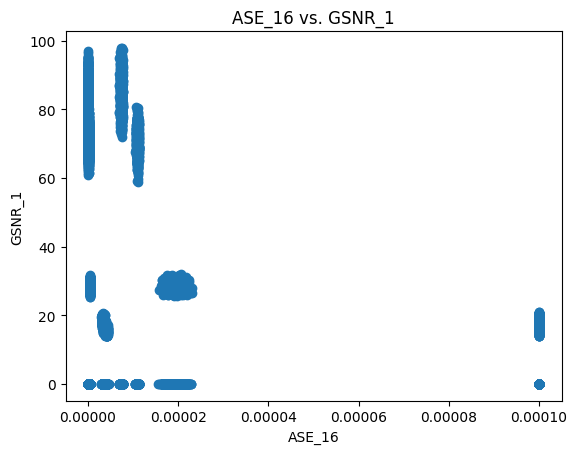

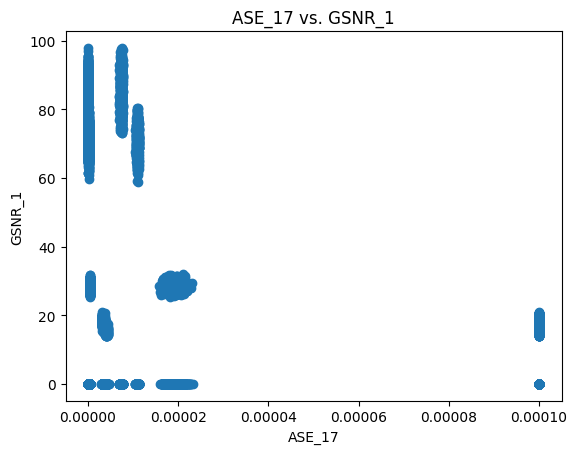

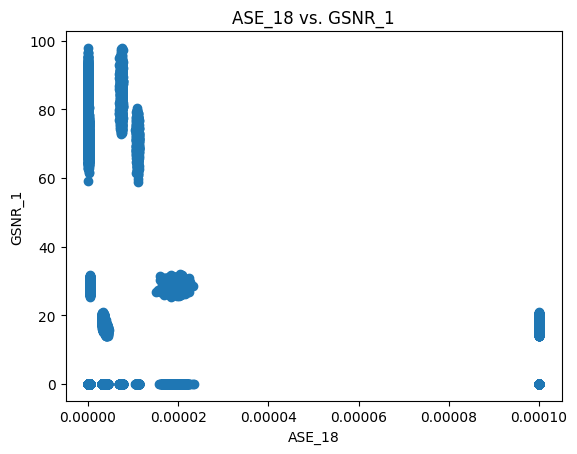

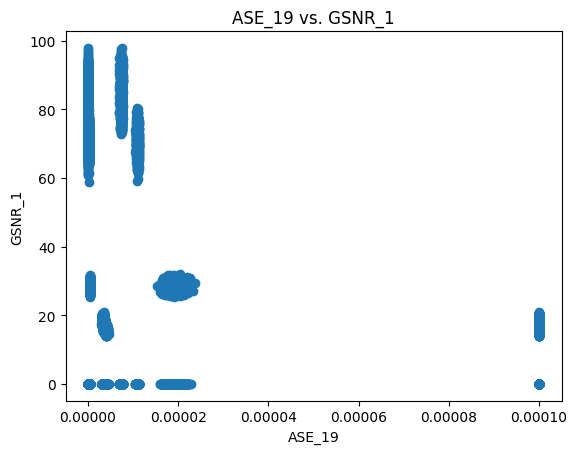

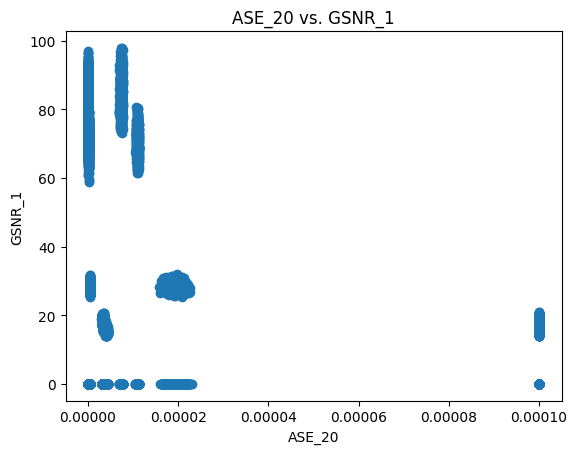

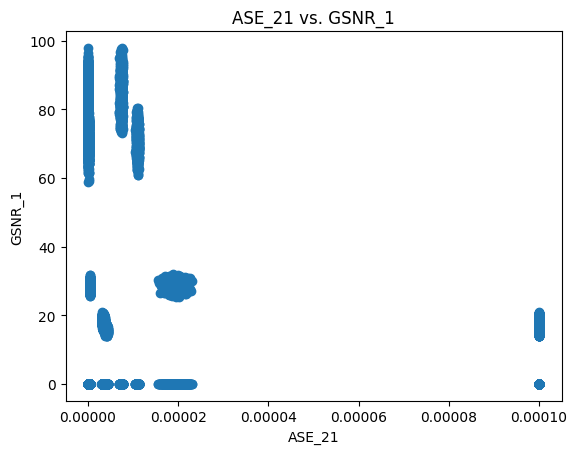

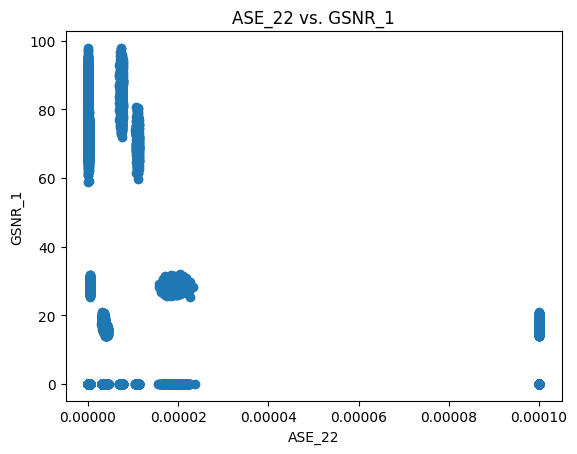

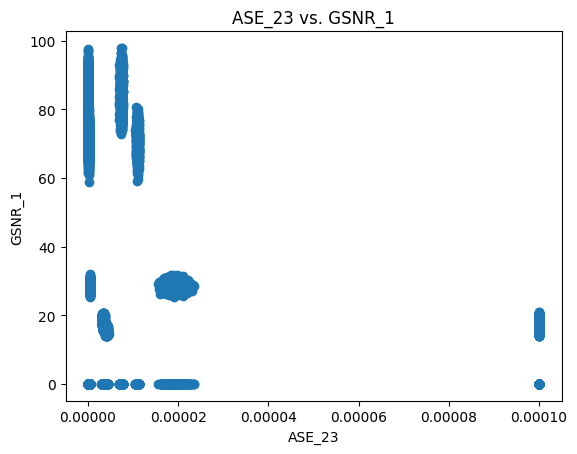

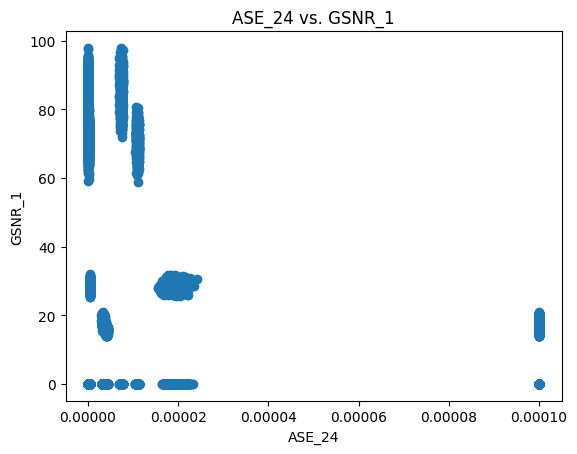

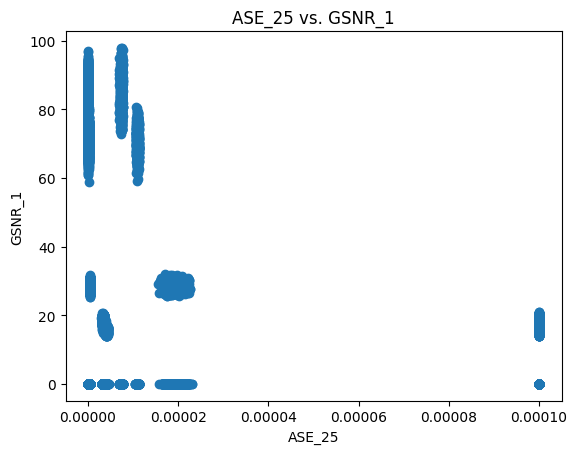

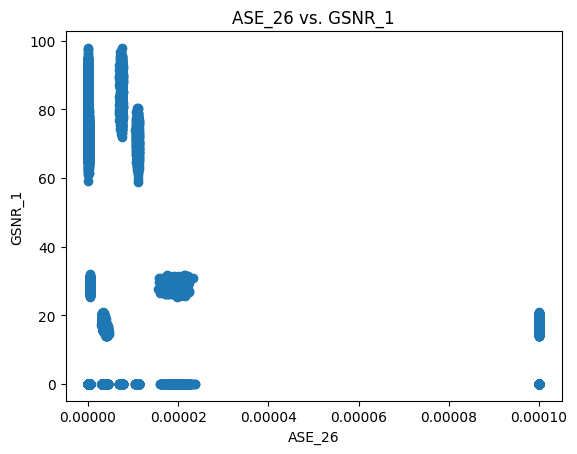

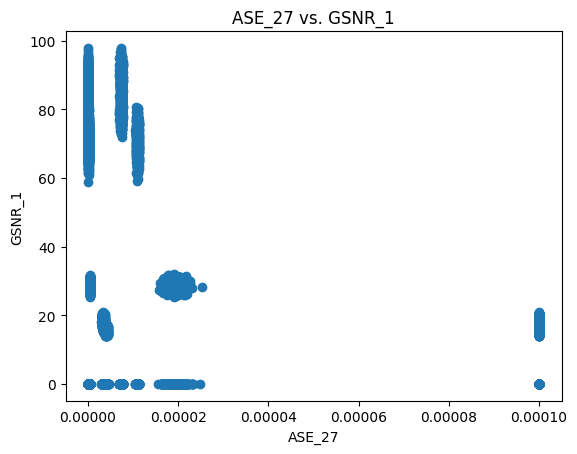

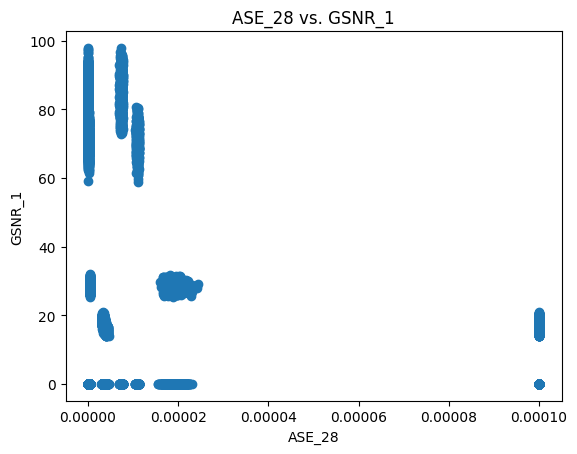

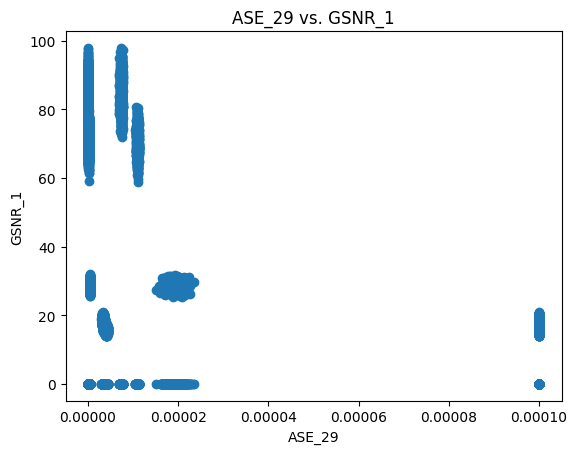

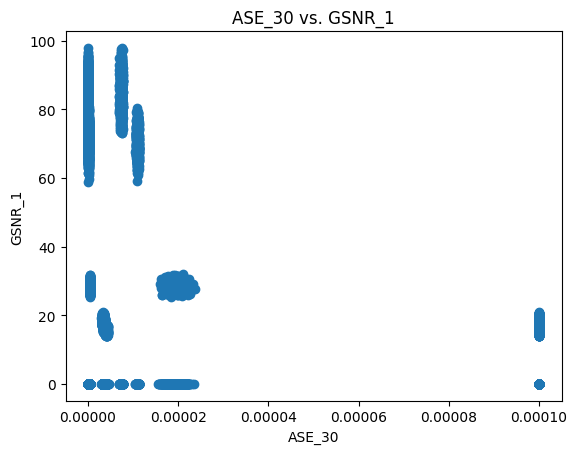

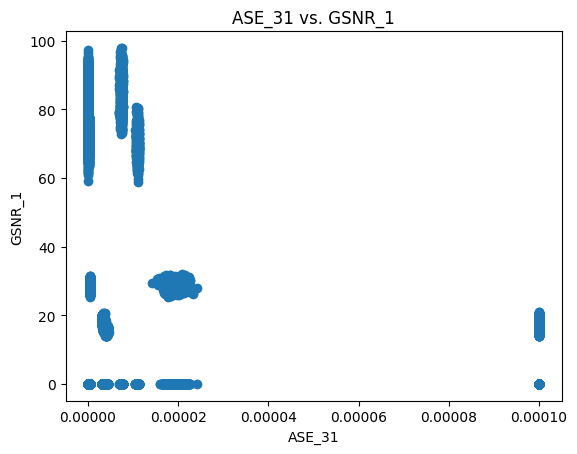

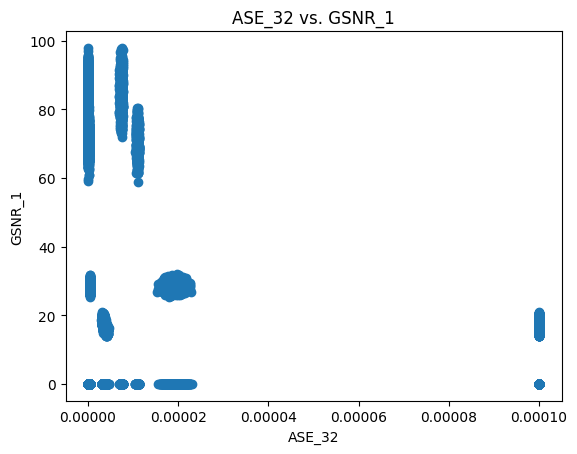

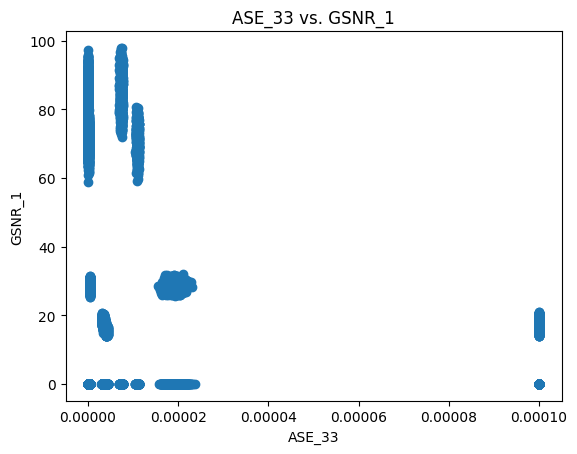

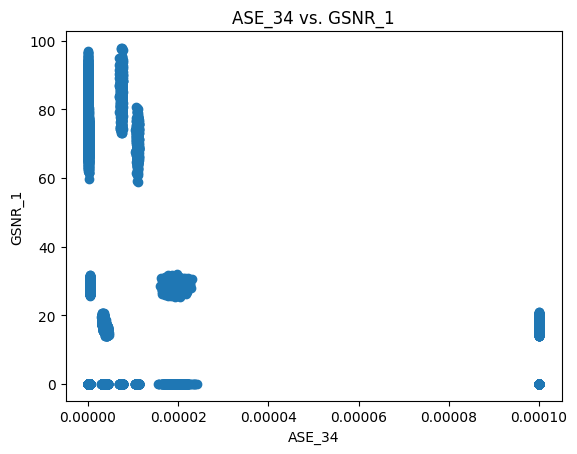

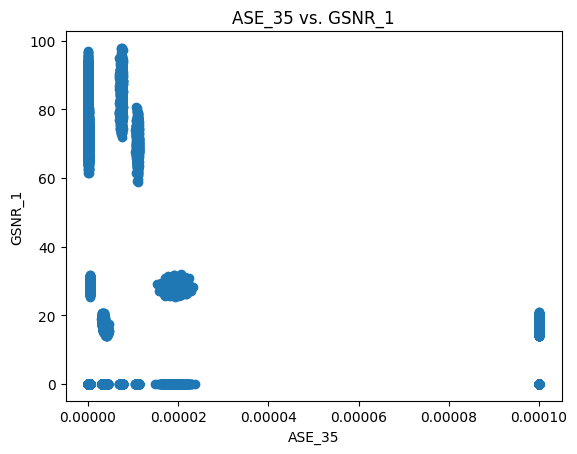

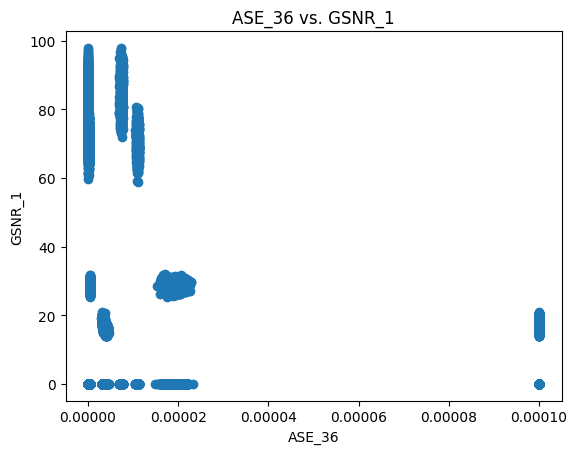

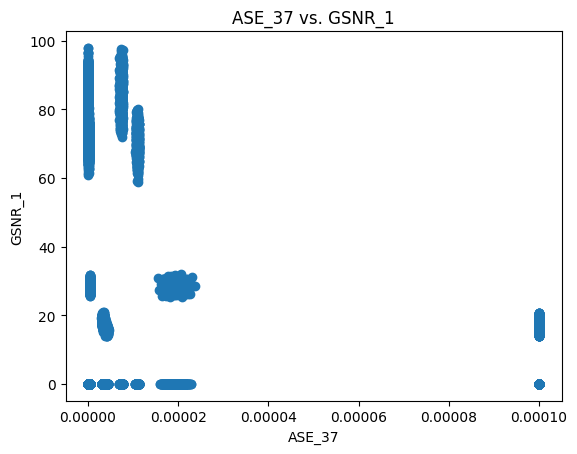

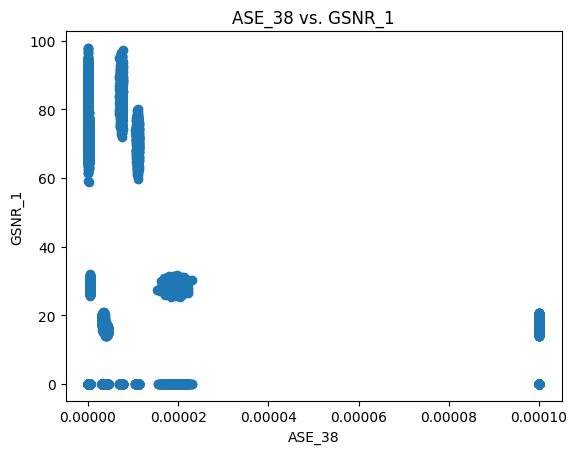

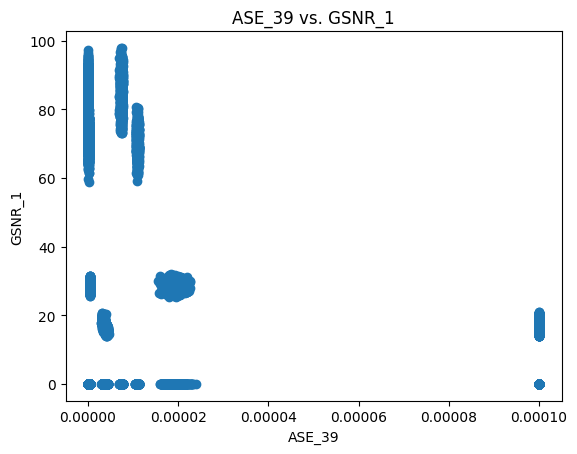

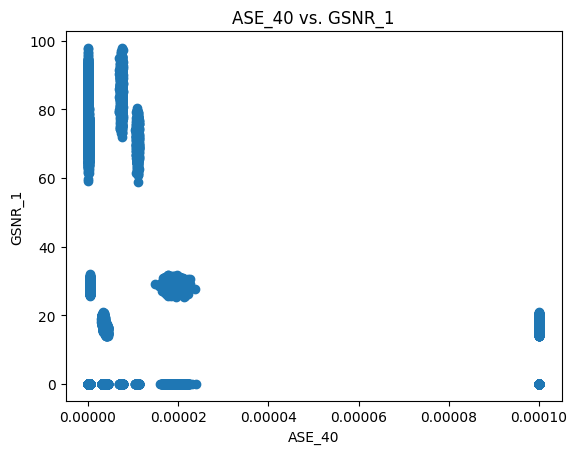

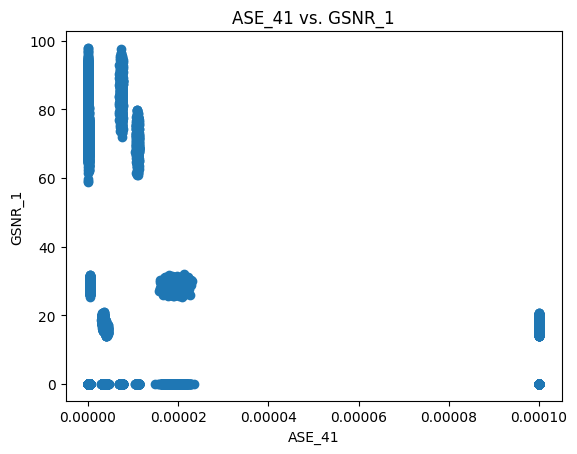

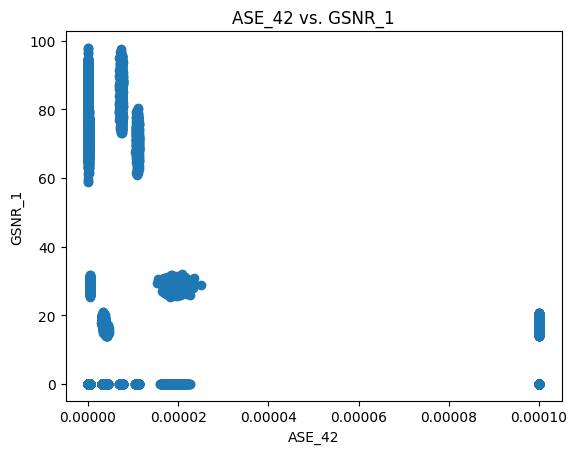

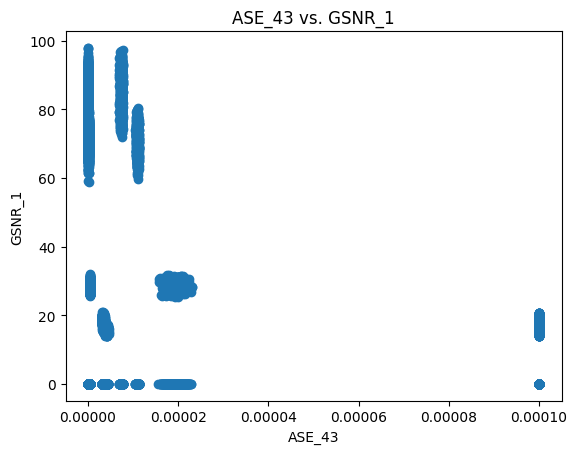

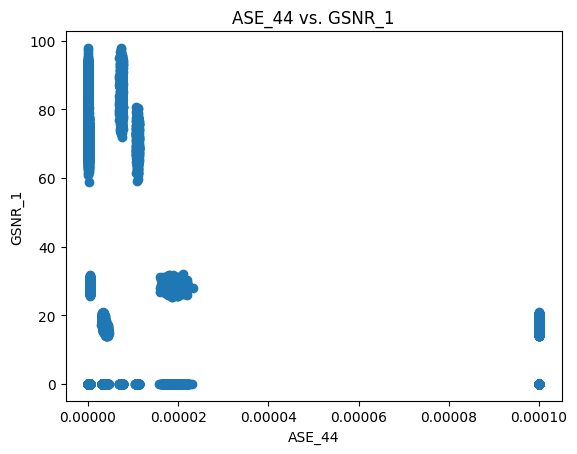

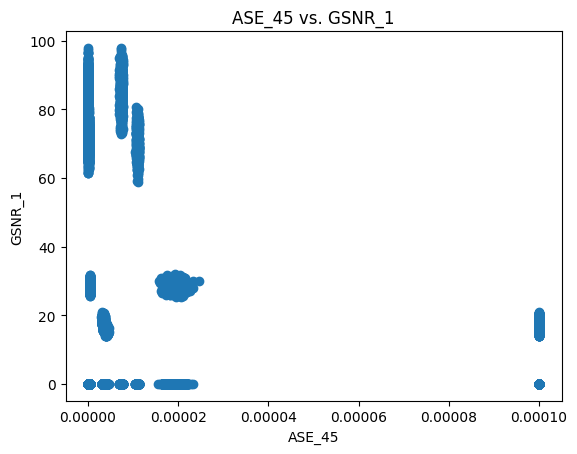

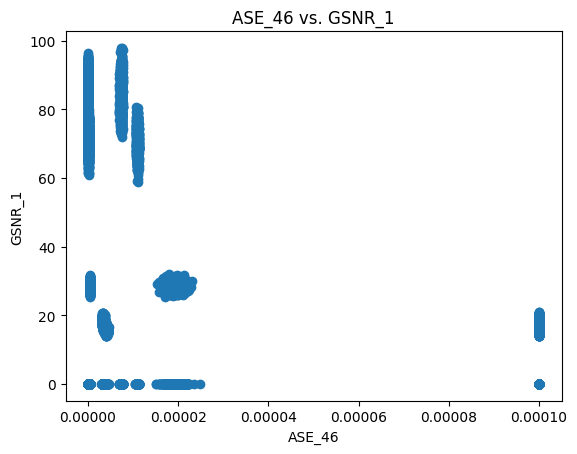

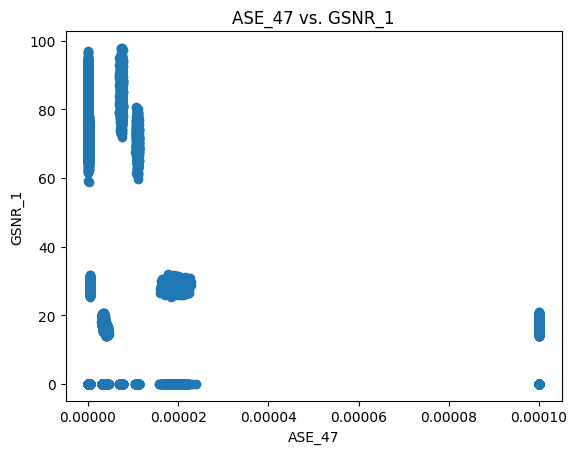

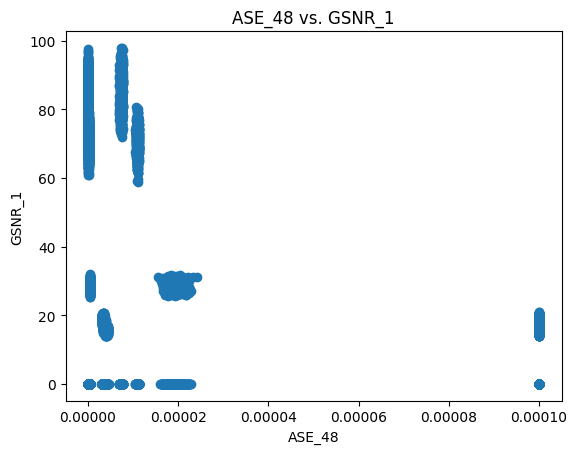

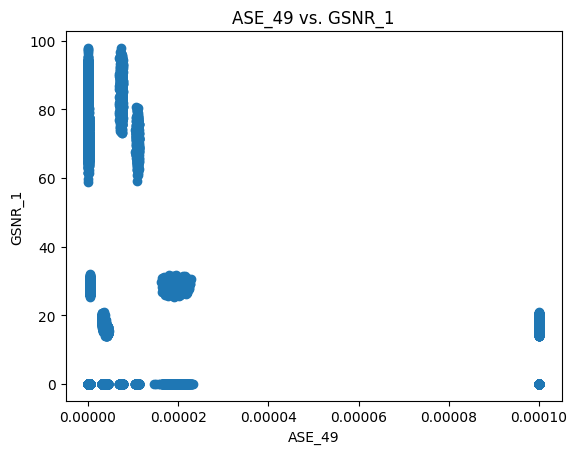

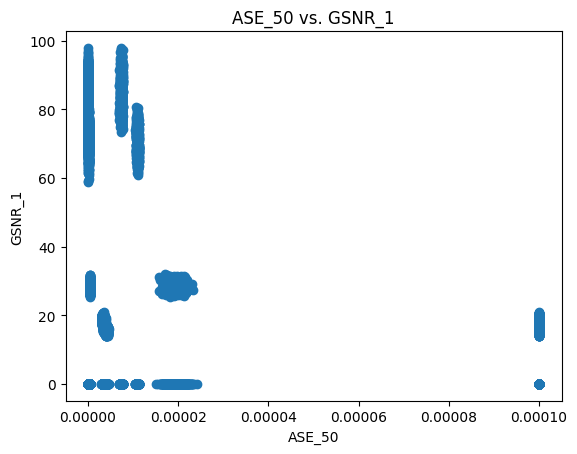

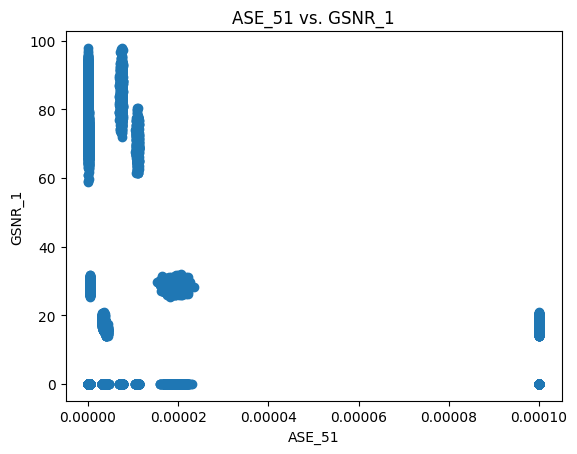

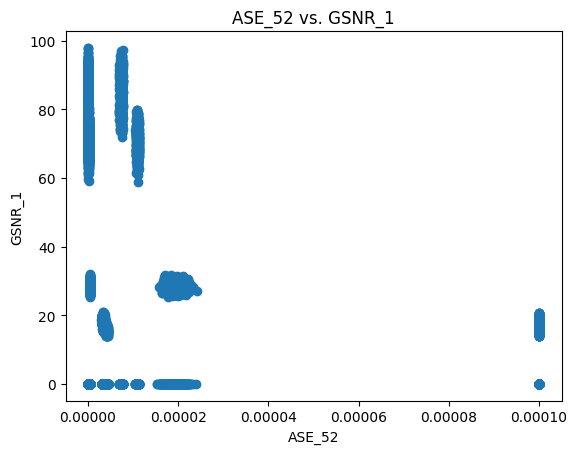

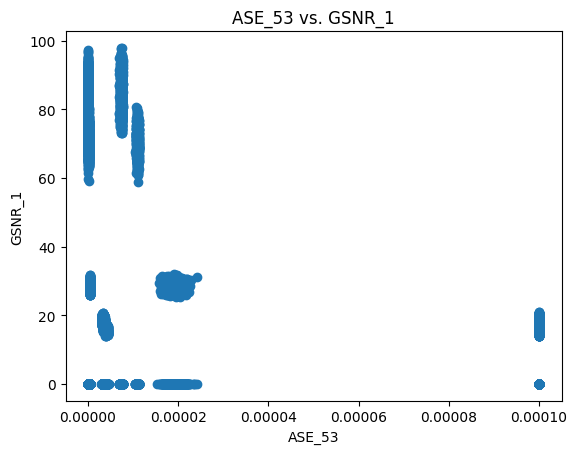

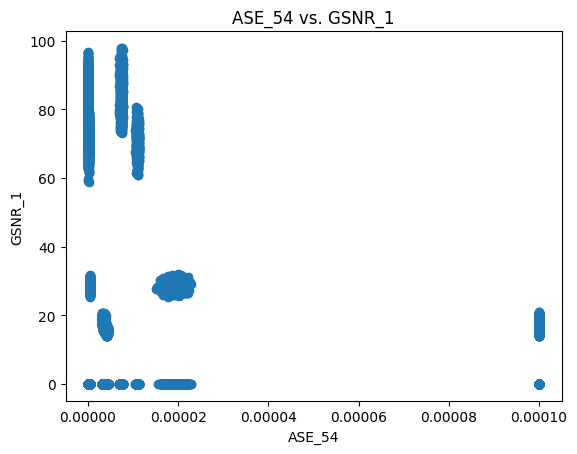

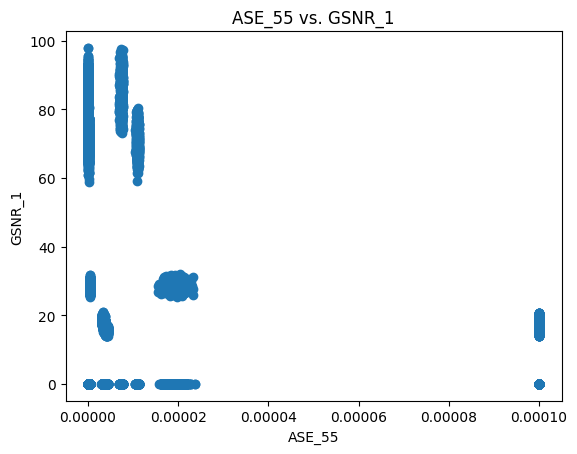

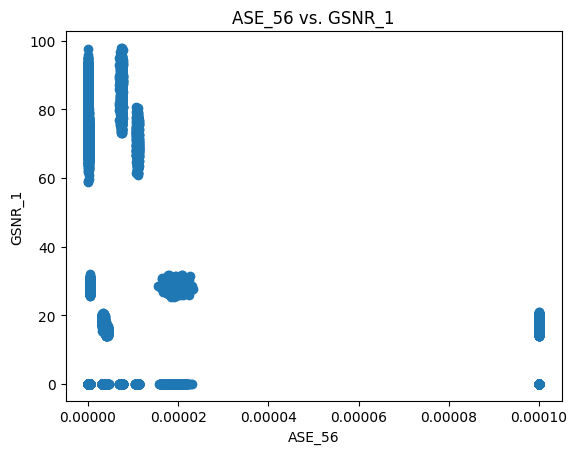

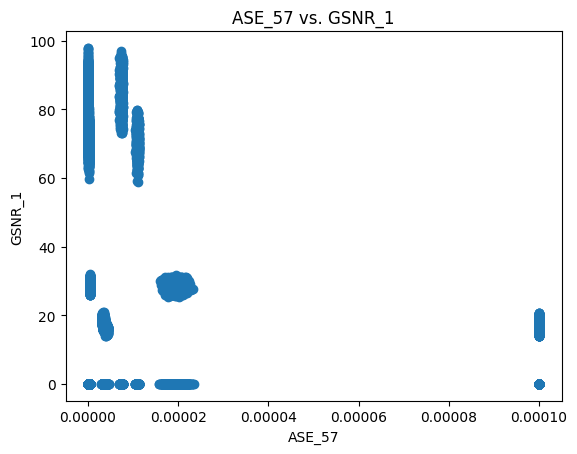

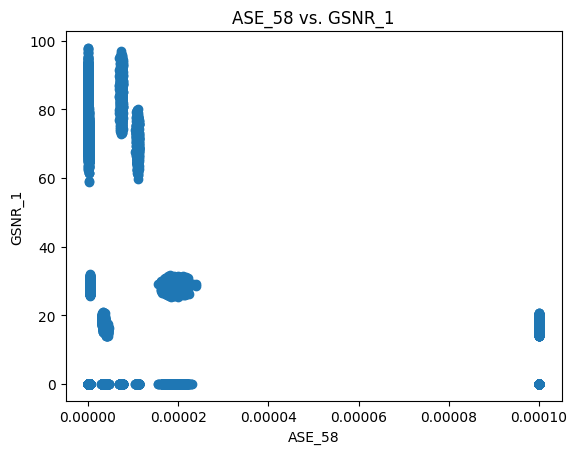

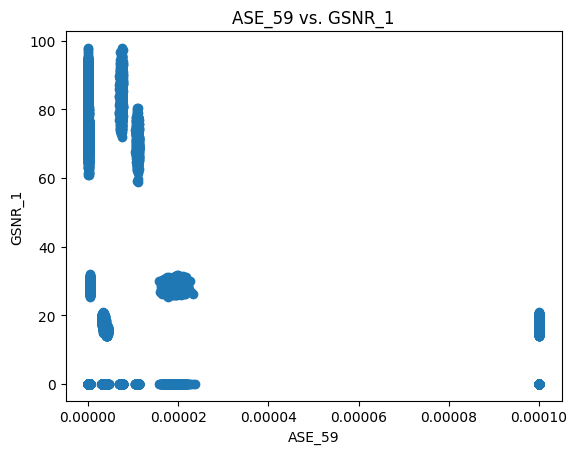

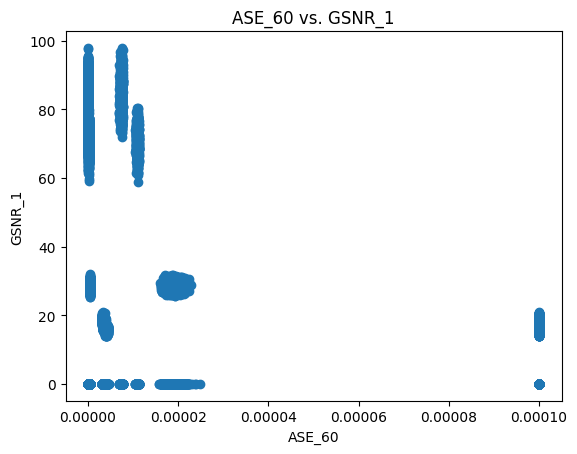

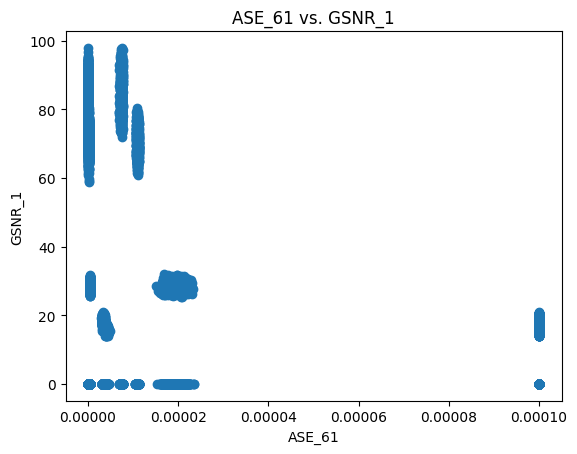

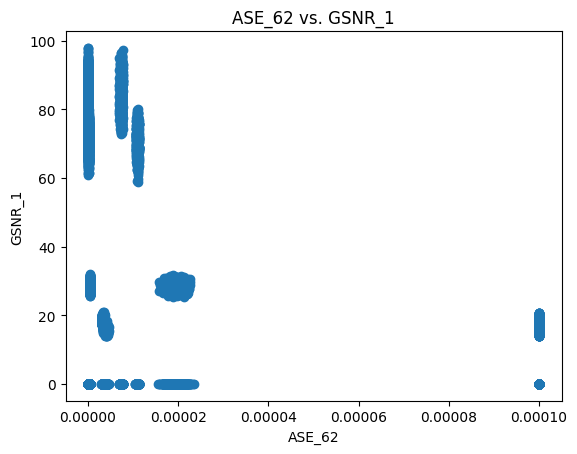

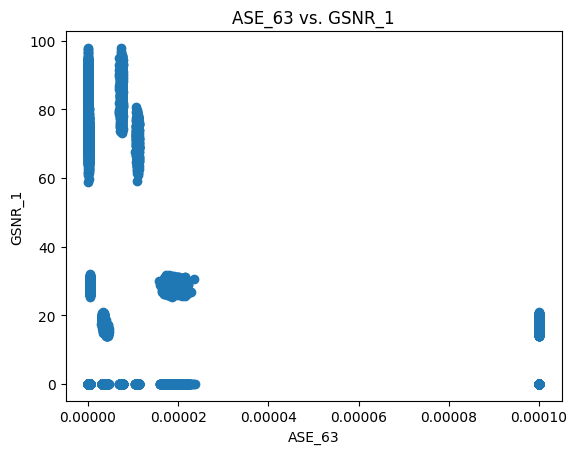

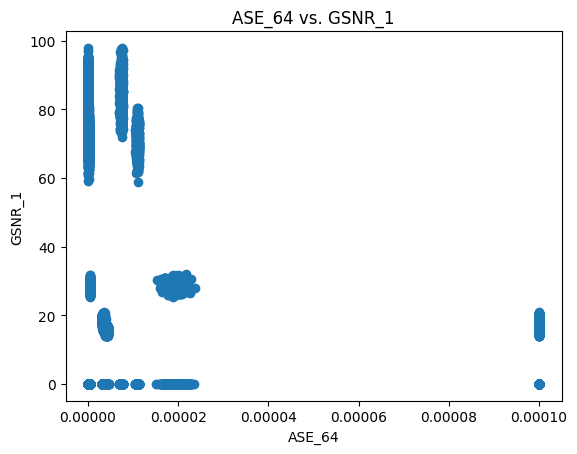

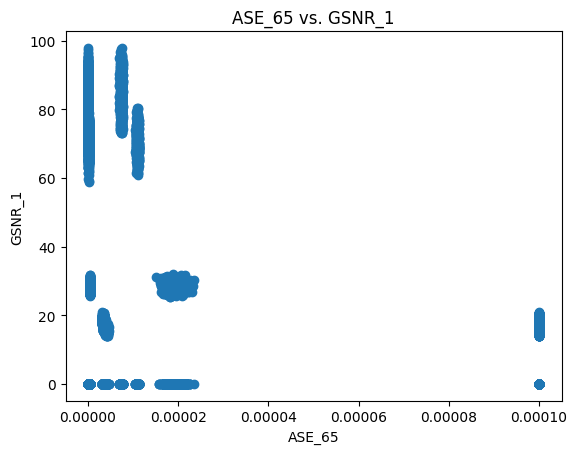

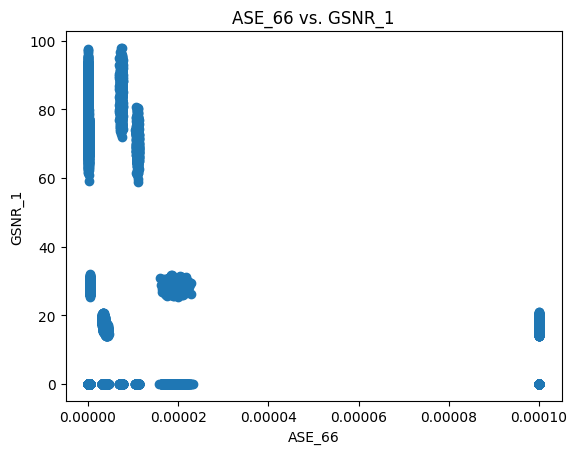

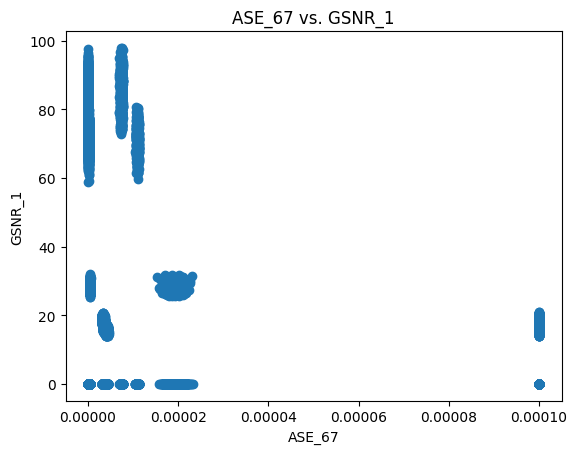

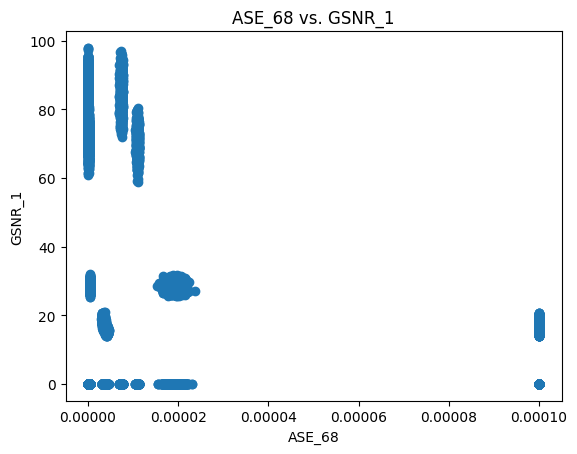

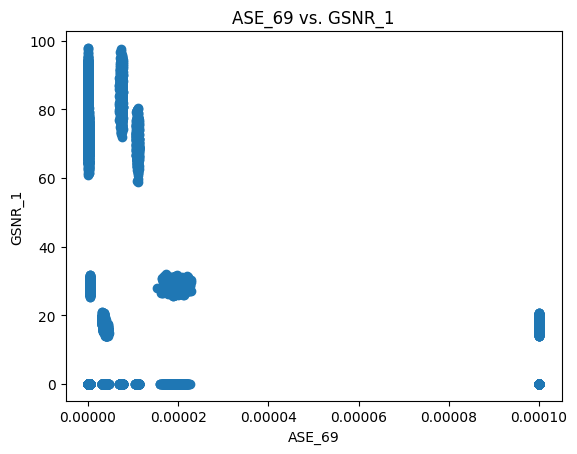

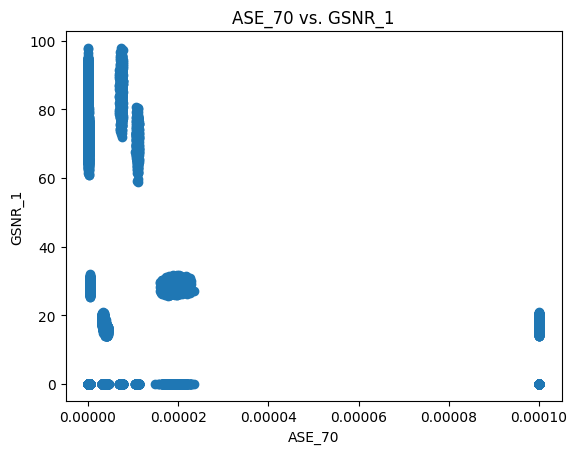

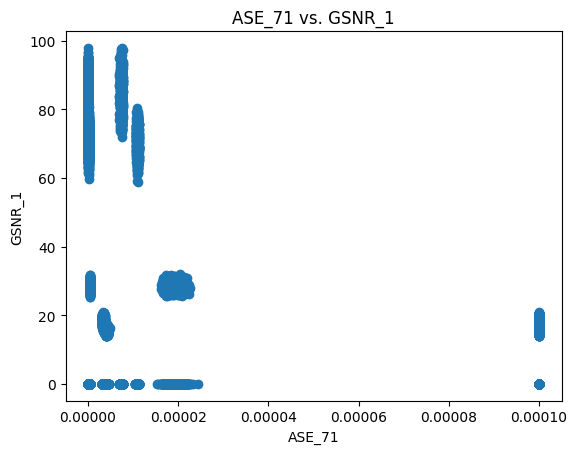

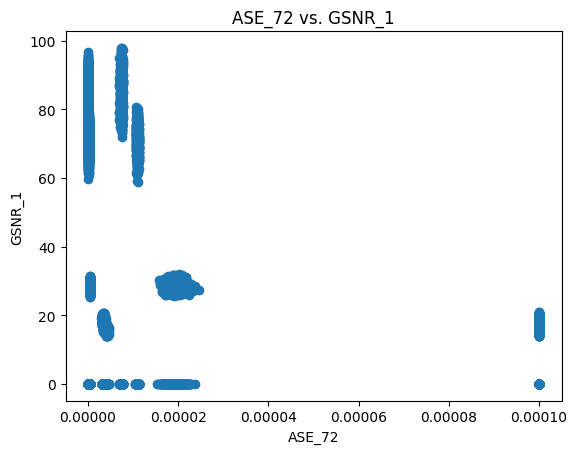

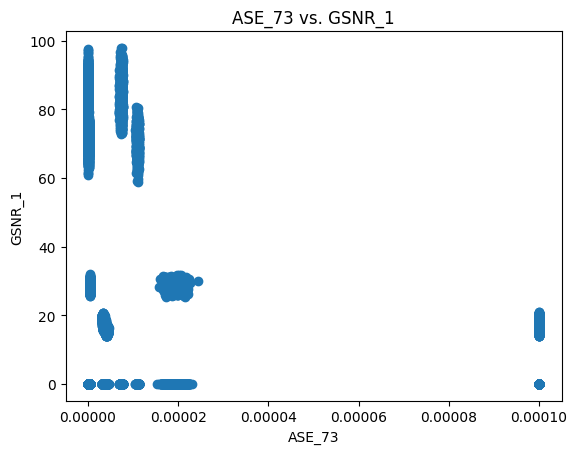

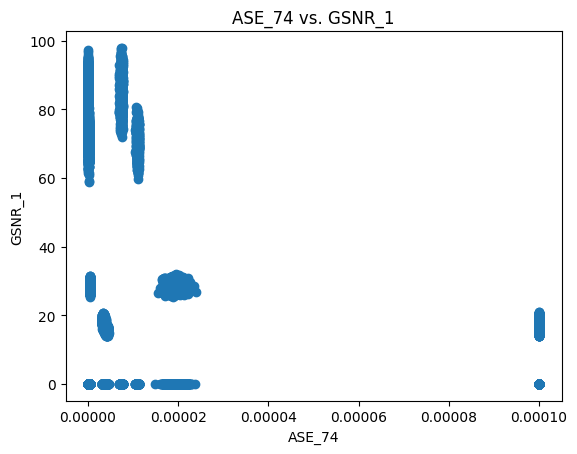

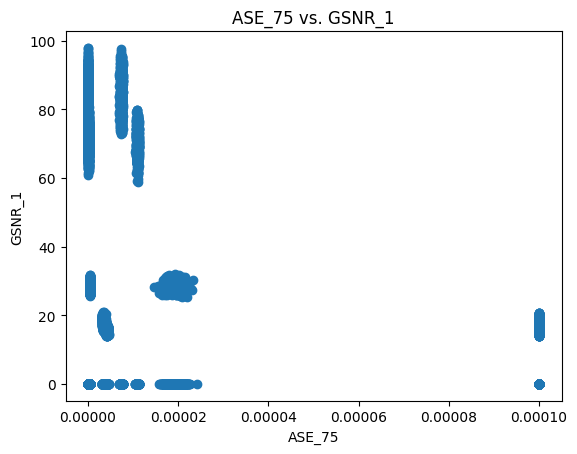

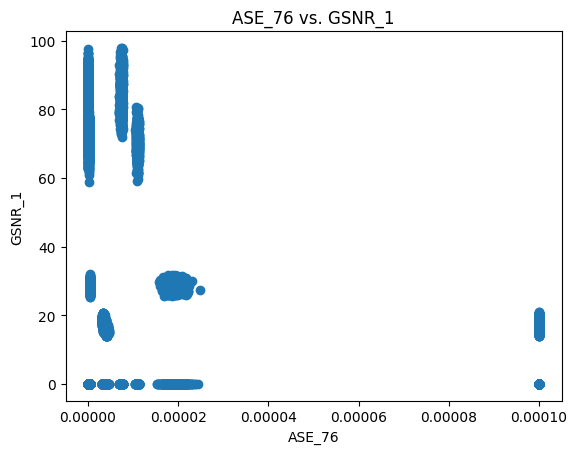

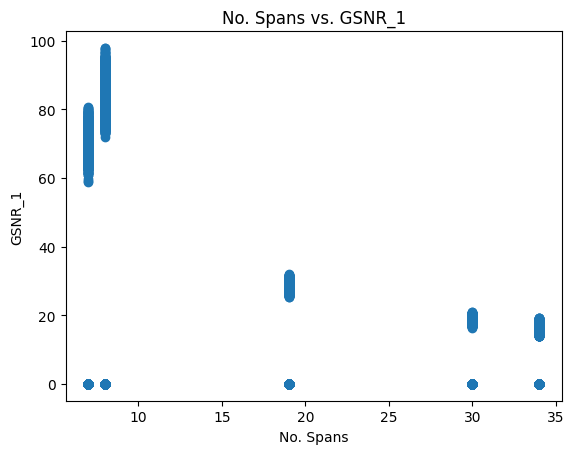

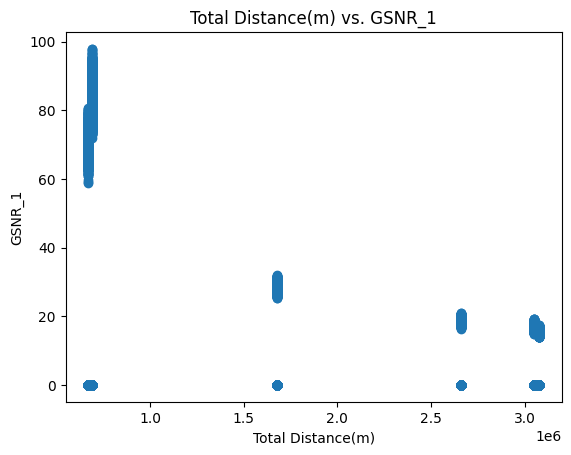

In [14]:
# Visualize the distribution of features and the target variable
for feature in X.columns:
    plt.figure()  # Create a new figure for each plot
    plt.scatter(X[feature], y)
    plt.xlabel(feature)
    plt.ylabel(gsnr_column)
    plt.title(f'{feature} vs. {gsnr_column}')
    plt.show()

**Splitting and scaling data**

In [15]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Scale the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

**4. Model Selection and Training**

In [17]:
input_shape = X_train_scaled.shape[1]

def build_model(hp):
    model = Sequential()

    # First layer with input shape specified
    model.add(Dense(64, activation='relu', input_shape=(input_shape,), name="Layer1"))
    model.add(Dense(units=hp.Choice('units', [8, 16, 32]),
                    activation=hp.Choice('activation1', ['relu', 'tanh'])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))

    # Additional layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Choice('units', [8, 16, 32]),
                        activation=hp.Choice('activation1', ['relu', 'tanh'])))
        model.add(Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='ONTTask2')

# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train_scaled, epochs=5, validation_data=(X_val_scaled, y_val_scaled))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


Trial 30 Complete [00h 00m 23s]
val_loss: 0.02275710552930832

Best val_loss So Far: 0.00603718776255846
Total elapsed time: 00h 04m 50s
Best hyperparameters:
units: 16
activation1: relu
dropout1: 0.0
num_layers: 2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013


Epoch 1/100
394/394 [==============================] - 2s 4ms/step - loss: 0.0312 - mean_absolute_error: 0.0846 - val_loss: 0.0206 - val_mean_absolute_error: 0.0716
Epoch 2/100
394/394 [==============================] - 2s 5ms/step - loss: 0.0236 - mean_absolute_error: 0.0740 - val_loss: 0.0259 - val_mean_absolute_error: 0.0720
Epoch 3/100
394/394 [==============================] - 2s 5ms/step - loss: 0.0179 - mean_absolute_error: 0.0669 - val_loss: 0.0147 - val_mean_absolute_error: 0.0581
Epoch 4/100
394/394 [==============================] - 2s 6ms/step - loss: 0.1493 - mean_absolute_error: 0.1904 - val_loss: 0.1839 - val_mean_absolute_error: 0.2688
Epoch 5/100
394/394 [==============================] - 1s 3ms/step - loss: 0.0707 - mean_absolute_error: 0.1342 - val_loss: 0.0128 - val_mean_absolute_error: 0.0683
Epoch 6/100
394/394 [==============================] - 2s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0561 - val_loss: 0.0071 - val_mean_absolute_error: 0.0462
Epoch 7/10

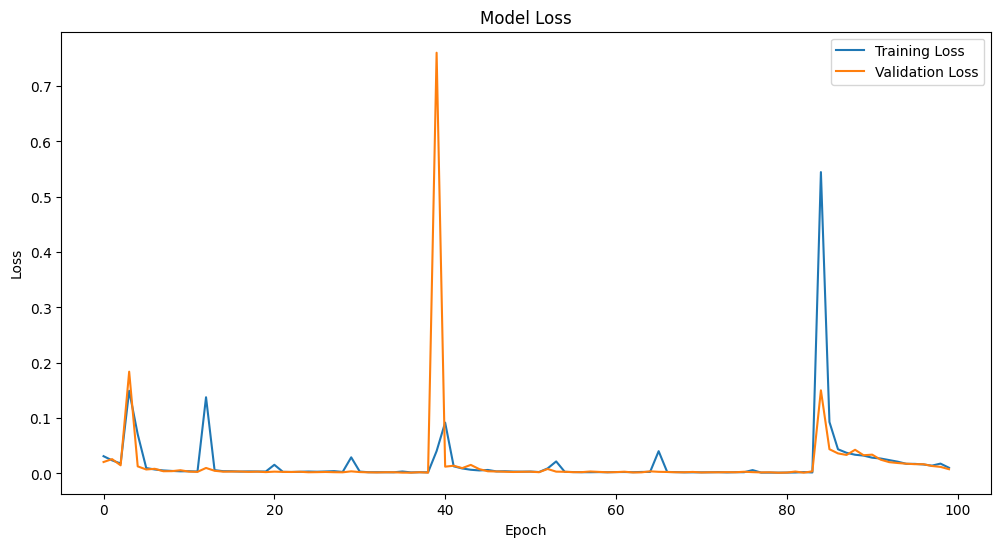

In [20]:
history = best_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,  # Use the best number of epochs
    batch_size=32,
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Evaluate the best model on the validation set
val_loss, val_mae = best_model.evaluate(X_val_scaled, y_val_scaled, verbose=0)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Validation Loss: 0.007613852620124817, Validation MAE: 0.043250229209661484
Test Loss: 0.007190813776105642, Test MAE: 0.04385636746883392


**4. Model Evaluation**

85/85 [==============================] - 0s 1ms/step


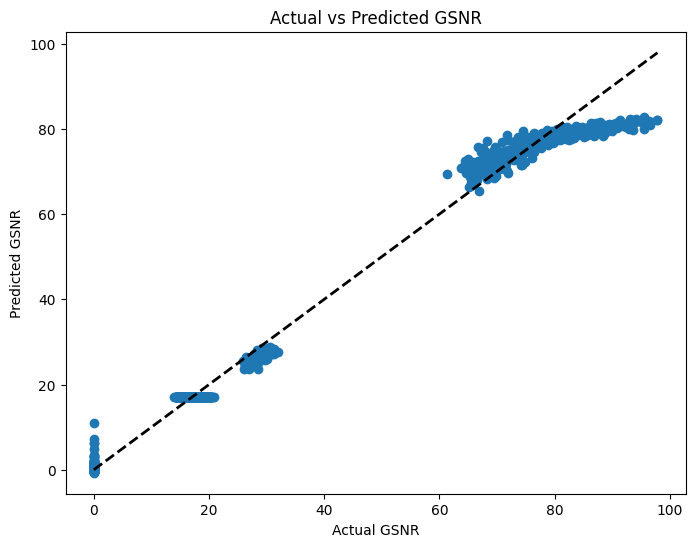

In [22]:
# Predictions and performance visualization
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual GSNR')
plt.ylabel('Predicted GSNR')
plt.title('Actual vs Predicted GSNR')
plt.show()

In [23]:
# Metrics for the final model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")
print(f"Test MAE: {mae}")

Test MSE: 5.297048206993947
Test R2: 0.9928528688174603
Test MAE: 1.1903115338372496
